# this code is analysis of experiment using code built with positive control data
[I used simulation data for two systems. In both the Smad pathway is simulated identically, with random noise in parameters and protein expression. The differene in the two systems is that in system 1, [gene = f(Smad3/4)], target gene expression depends directly on nuclear Smad3/Smad4, and in system 2, [gene = f(Smad3/4 , X)] target gene expression depends on nuclear Smad3/Smad4 and a randomly varying other factor, X (which in this case is a factor that affects how strongly Smad3/4 induces gene expression.]

From the simulated data, I use full trajectories for the level nuclear Smad3--that is the concentration of all species of Smad3 in the nucleus, such as would be observed in a microscope. (Note, I am not using trajectories for Smad3/Smad4 complex, which is the actual molecular complex on which gene production depends. I do not use these trajectories because they are not measurable in cells). Second, I use full trajectories of target gene production. For gene expression I analyze either A) a gene whose production depends directly on Smad3/Smad4 binding, or B) a gene whose production depends on a small network motif (3-nodes total, I-FFL1 specifically) that causes production of gene to be proportional to the fold-change in Smad3/Smad4 complex.

For experimental analysis, I take trajectories of nuclear NG-Smad3, which were measured in single cells from experiments and I take trajectories of total nuclear Snail:mCherry (or median, see next experiment). I first run diffusion maps on the NG-Smad3 trajectories to obtain a good DMAP for NG-Smad3. Then I obtain a DMAP for Snail using the same method. Then I use Gaussian Process Regression to assess whether Snail dynamics (i.e. Snail DMAP) can be predicted using Smad3 dynamics (i.e. Snail DMAP). 

In order to obtain a good diffusion map, I prepare (process?) the original data in the following way.
1. First, I take raw data as is. This is matrix1. (Matrix1 is M cells X N timepoints)
2. Then I take the raw data and compute the derivative of each trajectory. This is matrix 2. 
3. Then I take the raw data and compute the integral of each trajectory. This is matrix 3. 
4. Then I combine matrices 1, 2 and 3 into one new matrix, MatrixCAT (MatrixCAT is M cells X 3*N timepoints)
5. Then I transform this data set (in a way the preserves the topology of the data set) by normalizing all trajectories at each time point using the following:
    MT = MatrixCAT[t,:] (t=1)
    [MT is an 1 x M array, where M is the number of cells]
    MTn = MT-min(MT)/(max(MT)-min(MT)
    MTns = sqrt(MTn)
    MatrixCATztos[t,:] = MTns
    [I do this for all timepoints]
6. This transformation preserves topology, and it ensures that the difussion distances are similar for each dimension, which is important for finding a good difussion kernel for the diffusion map algoritm. 
7. By including raw data, first derivative of data, and integral of data were are enableing the algorithm to find a difussion Map that uncovers the dynamical features of the data set. 


    

In [1]:
from pathlib import Path
cwd = Path().resolve()
print(cwd)

/Users/frick/Dparams/DParamsFinal_v4


# this code uses Snail TOTAL

In [3]:
from pathlib import Path
cwd = Path().resolve()
print(cwd)
import sys
sys.path.insert(0, cwd) 

conditionid = 'exp3'
specid = 'mdl_S3conc_CAGAconc_gpy_-DIFF-positive_LLRpeakfinder_CLEAN-AGNOSTIC-ztosqrtResampleCAGA'
cond2 = 'tcut'
exp_path = '' + conditionid + '/'
csvsavepath = '_dmap_csv_' + conditionid + cond2+ specid + 'clean/'
print(specid)

repo = str(cwd) +'/'

data_path = repo + exp_path + "/"
data_path2 = data_path
fig_path = repo + "testfig/"

#determine data for generating input and output maps
if conditionid == 'exp4' or conditionid == 'exp3':
    params = "smadMatrix.csv"
    params2 = "outputMatrixTOTAL.csv"
    timematrix = "timematrix.csv"
    datamatrix = "dosageData.csv"
    filename = data_path + params
    tcut = 'no'
    tscale = 'no'
else:
    params = "rsmad.csv"
#     params2 = "zgene.csv"
    params2 = 'cagagene.csv'
    timematrix = "timematrix.csv"
    datamatrix = "dosageData.csv"
    filename = data_path + params
    print('it elsed')
    tcut = 'yes'
    tscale = 'yes'
    

#in this processed form, I find that using DMAPs does not improve the accuracy of representing the data above using timepoint combinations
#smad abundance vs Snail difference

#this is bad ass
from pathlib import Path
cwd = Path().resolve()
print(cwd)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as manimation
import numpy as np

import matplotlib.tri as mtri

from scipy.integrate import odeint
from scipy.integrate import complex_ode
import scipy.spatial.distance
import scipy
import scipy.interpolate
import scipy.signal

import re

from dmap_sp_chrisNEW import *

import dmap_sp_chrisNEW
import importlib
importlib.reload(dmap_sp_chrisNEW)


import os
print(not (os.path.isdir(fig_path)))
if not (os.path.isdir(fig_path)):
    print('making' + fig_path)
    os.mkdir(fig_path)

name = "16CHRIS"
%matplotlib inline

/Users/frick/Dparams/DParamsFinal_v4
mdl_S3conc_CAGAconc_gpy_-DIFF-positive_LLRpeakfinder_CLEAN-AGNOSTIC-ztosqrtResampleCAGA
/Users/frick/Dparams/DParamsFinal_v4
False


In [4]:
from accessory import *

In [5]:

crs = open(filename, "r")
counter = 1
for columns in ( raw.strip().split() for raw in crs ):  
    if counter > 1:
        break
    counter+=1


# load data files and rescale as necessary
datamatrix_path_in = data_path + params
datamatrix_path_out = data_path + params2
timematrix_path = data_path + timematrix
dosage_path = data_path + datamatrix

observed_data_in0 = np.genfromtxt(datamatrix_path_in, missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
observed_data_out0 = np.genfromtxt(datamatrix_path_out, missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
time_data0 = np.genfromtxt(timematrix_path, missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
dosage_data = np.genfromtxt(dosage_path, missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

In [6]:
def plot_all_doses(yset,t1,dosage_data):
    udose = np.unique(dosage_data)
    if len(udose)>10:
        dosage_data = np.round(dosage_data,1)
        udose = np.unique(dosage_data)
        print(udose)
    fig = plt.figure(figsize=(14,2))
    for i in range(len(udose)):
        u = udose[i]
        dd = np.where(dosage_data==u)
        didx = dd[0]
        ax = fig.add_subplot(1,len(udose),i+1)
        x = t1[didx,:]
        y = yset[didx,:]
        plt.plot(x.T,y.T)
        plt.ylim(np.min(yset.flatten()),np.max(yset.flatten()))
        plt.title(u)
        
    fig.subplots_adjust(wspace=0.3)
  


In [7]:
observed_data_in = observed_data_in0.copy()
observed_data_out = observed_data_out0.copy()    
time_data = time_data0.copy()
in0 = observed_data_in.copy() 
out0 = observed_data_out.copy()
t0 = time_data.copy()

if tcut == 'yes':
    tvec = t0[1,:]
    idx = (tvec<2) & (tvec>-0.5)
    t2 = (np.where(idx))[0]
    print(t2)
    observed_data_in = observed_data_in[:,t2]
    observed_data_out = observed_data_out[:,t2]  
    if tscale == 'yes':
        time_data = time_data[:,t2]*60
    else:
        time_data = time_data[:,t2]

observed_data_in[np.isnan(observed_data_in)] = 0
observed_data_out[np.isnan(observed_data_out)] = 0
print(np.sum(np.isnan(observed_data_in)))


0


/Users/frick/Dparams/DParamsFinal_v4/_dmap_csv_exp3tcutmdl_S3conc_CAGAconc_gpy_-DIFF-positive_LLRpeakfinder_CLEAN-AGNOSTIC-ztosqrtResampleCAGAclean/


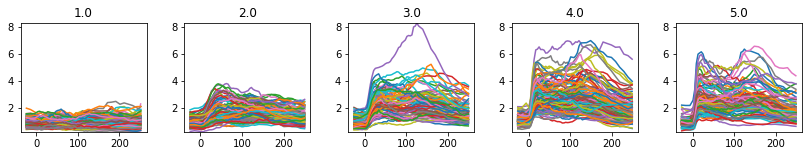

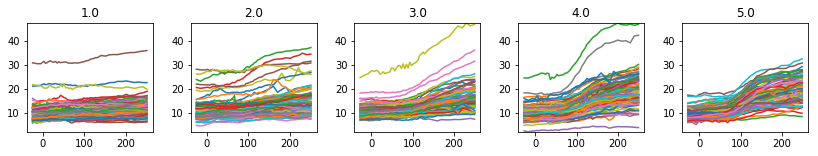

In [8]:
plot_all_doses(observed_data_in.copy(),time_data.copy(),dosage_data)  
plot_all_doses(observed_data_out.copy(),time_data.copy(),dosage_data)  

newcsvpath = repo + csvsavepath

if not os.path.exists(newcsvpath):
    os.makedirs(newcsvpath)
print(newcsvpath)
a = numpy.asarray(observed_data_in)
numpy.savetxt(newcsvpath+"smadMatrix_PYdat.csv", a, delimiter=",")
a = numpy.asarray(observed_data_out)
numpy.savetxt(newcsvpath+"outputMatrixDIFF_PYdat.csv", a, delimiter=",")
a = numpy.asarray(time_data)
numpy.savetxt(newcsvpath+"timeMatrix_PYdat.csv", a, delimiter=",")

In [9]:
def zero_one_individ(data):
    for k in range(0,data.shape[1]):   
        data[:,k] = data[:,k] - np.min(data[:,k])
        data[:,k] = data[:,k] / np.max(data[:,k])
    #     observed_data_in[:,k] = np.log(observed_data_in[:,k]+1e-0)
        data[:,k] = np.sqrt(data[:,k])
    return data

def zero_one_population(data):
    ogdingrad = data.copy()
    for k in range(0,data.shape[0]):  
        data[k,:] = data[k,:] - np.min(ogdingrad[:])
        data[k,:] = data[k,:] / (np.max(ogdingrad[:])-np.min(ogdingrad[:]))
    return data

def zero_one_dimension(data):
    ogdingrad = data.copy()
    for i in range(0,data.shape[1]):  
        dimdat = ogdingrad[:,i]
        for k in range(0,data.shape[0]):  
            data[k,i] = data[k,i] - np.min(dimdat[:])
            data[k,i] = data[k,i] / (np.max(dimdat[:])-np.min(dimdat[:]))
    return data

def zero_one_sqrt(data):
    for k in range(0,data.shape[1]):
        if np.std(data[:,k])>1e-14:
            data[:,k] = data[:,k] - np.min(data[:,k])
            data[:,k] = data[:,k] / np.max(data[:,k])
            #observed_data_out[:,k] = np.log(observed_data_out[:,k]+1e-0)
            data[:,k] = np.sqrt(data[:,k])
        else:
            print('low sqrt error at',k)
    return data



def foldchangefunc(data_in,time_in,basalwindow):
    tvec = time_in[1,:]
    tidx = ((tvec<basalwindow[1]) & (tvec>=basalwindow[0]))
    basal0 = np.where(tidx)
    basal = basal0[0]
    ogdata_in = data_in.copy()
    for k in range(0,data_in.shape[0]):  
        data_in[k,:] = data_in[k,:]/np.median(ogdata_in[k,basal])
    return data_in   
    
    

def differencefunc(data_in,time_in,basalwindow):
    tvec = time_in[1,:]
    tidx = ((tvec<basalwindow[1]) & (tvec>=basalwindow[0]))
    basal0 = np.where(tidx)
    basal = basal0[0]
    ogdata_in = data_in.copy()
    for k in range(0,data_in.shape[0]):  
        data_in[k,:] = data_in[k,:]-np.median(ogdata_in[k,basal])
    return data_in   



def resampledata(data_in,time_in,gradcut,rlh):
    tvec = time_in[1,:]

#     tvec = time_data[1,:]-np.min(time_data[1,:])
    pt = np.gradient(data_in.copy(),tvec,axis=1)
    pt = np.gradient(pt,tvec,axis=1)
    pt = np.abs(pt)
    pt = np.median(pt,axis=0)
    pt = (pt-np.min(pt))/(np.percentile(pt,95)-np.min(pt))
    plt.semilogy(pt.T)
    plt.semilogy([0,len(pt)],[gradcut,gradcut])
    plt.ylim(1e-9,10)
    plt.show()

    firstT = np.where(pt>gradcut)
    tx = firstT[0]
    tx1i = np.max((tx[0]-1,0))
    tx2i = tx[-1]
    print([tx1i,tx2i])
    tkeep = [tx1i,tx2i]
    
    lowreg = rlh[0] #every 60 minutes
    highreg = rlh[1] #every 10 minutes
    
    treg = np.ceil((tvec[tkeep[0]]-tvec[0])/lowreg)
    tinterp1 = np.linspace(tvec[0],tvec[tkeep[0]],treg)
    
    treg = np.ceil((tvec[tkeep[1]]-tvec[tkeep[0]+1])/highreg)
    tinterp2 = np.linspace(tvec[tkeep[0]+1],tvec[tkeep[1]],treg)
    
    treg = np.ceil((tvec[-1]-tvec[tkeep[1]+1])/lowreg)
    tinterp3 = np.linspace(tvec[tkeep[1]+1],tvec[-1],treg)
    tinterp = np.hstack((tinterp1,tinterp2,tinterp3))
    print(tinterp)
    
    keep_in = data_in.copy()
    x = tinterp
    time_datanew = np.zeros((keep_in.shape[0],len(x)))
    obsdnew = np.zeros((keep_in.shape[0],len(x)))
    for k in range(0,data_in.shape[0]): 
        xp = time_in[k,:]
        fp = keep_in[k,:]
        yp = numpy.interp(x, xp, fp, left=None, right=None, period=None)
        obsdnew[k,:] = yp
        time_datanew[k,:] = x

    data_out = obsdnew
    time_out = time_datanew
    

    return data_out, time_out

In [10]:
# pvec = observed_data_in[1,:]
# tvec = time_data[1,:]-np.min(time_data[1,:])
# print(tvec.shape)
# print(pvec.shape)
# deriv = np.gradient(pvec.copy(),tvec)
# gradi = np.gradient(pvec.copy())
# plt.plot(deriv)
# plt.plot(gradi)

In [11]:
# pvec = observed_data_in[1,:]
# tvec = time_data[1,:]-np.min(time_data[1,:])
# print(tvec.shape)
# print(pvec.shape)
# deriv = np.gradient(observed_data_in.copy(),tvec,axis=1)
# gradi = np.gradient(observed_data_in.copy(),axis=1)
# plt.plot(deriv.T,'k-')
# plt.plot(gradi.T,'r-')
# plt.show()

In [12]:
print('observed_data_in', observed_data_in.shape)
print('observed_data_out', observed_data_out.shape)
print('time_data', time_data.shape)
ogdin = observed_data_in.copy()
ogdout = observed_data_out.copy()
# tvec = time_data[1,:]
# print(tvec)

observed_data_in (425, 48)
observed_data_out (425, 48)
time_data (425, 48)


In [13]:
# # compute fold change
# basalwindow = [-30,0]
# data_in = observed_data_in.copy()
# time_in = time_data
# # observed_data_in = foldchangefunc(data_in,time_in,basalwindow)

# #compute gradient
# data_in = observed_data_in.copy()
# tvec = time_in[1,:]
# # observed_data_in = np.gradient(observed_data_in.copy(),tvec,axis=1)
# # observed_data_in = np.gradient(data_in,axis=1)

# #compute difference
# basalwindow = [-30,0]
# data_in = observed_data_out.copy()
# time_in = time_data
# # observed_data_out = differencefunc(data_in,time_in,basalwindow)


# observed_data_in = zero_one_sqrt(observed_data_in)
# observed_data_out = zero_one_sqrt(observed_data_out)

# time_data_in = time_in.copy()
# data_in = observed_data_in.copy()
# time_in = time_data
# gradcut = 0.1
# resamplelohi = [20,3]
# observed_data_in, time_data_in = resampledata(data_in,time_in,gradcut,resamplelohi)
    
# time_data_out = time_in.copy()
# data_in = observed_data_out.copy()
# time_in = time_data
# gradcut = 0.1
# resamplelohi = [20,3]
# observed_data_out, time_data_out = resampledata(data_in,time_in,gradcut,resamplelohi)


# # observed_data_in = zero_one_population(observed_data_in)
# # observed_data_out = zero_one_population(observed_data_out)

# # observed_data_in = zero_one_sqrt(observed_data_in)
# # observed_data_out = zero_one_sqrt(observed_data_out)

# print('done')

In [14]:

def stackABS_GRAD_INT(observed_data_in,time_in):
    for v in range(0,3):
        if v == 0:        
            data_in = observed_data_in.copy()
            time_in = time_data
            observed_data_in1 = data_in
        if v == 1:
            # compute gradient
            data_in = observed_data_in.copy()
            time_in = time_data
            tvec = time_in[1,:]
            observed_data_in2 = np.gradient(observed_data_in.copy(),tvec,axis=1)
        if v == 2:
            # compute fold change
            data_in = observed_data_in.copy()
            time_in = time_data
            tvec = time_in[1,:]
            observed_data_in3 = np.cumsum(observed_data_in.copy(),axis=1)
#             ocin = observed_data_in.copy()
#             for i in range(ocin.shape[0]):
#                 outty = [np.trapz(ocin[i,0:vv+1],tvec[0:vv+1],axis=1) for vv in range(ocin.shape[1])]
#                 print(outty)
#                 observed_data_in3[i,:] = outty
#             print(observed_data_in3)
            
    print(observed_data_in1.shape)
    print(observed_data_in2.shape)
    print(observed_data_in3.shape)
    datanew = np.hstack((observed_data_in1,observed_data_in2,observed_data_in3))
    time_data1 = time_data.copy() - np.min(time_data[:])
    time_data2 = time_data1.copy() + np.max(time_data1[:])
    time_data3 = time_data1.copy() + np.max(time_data2[:])
    timenew = np.hstack((time_data1,time_data2,time_data3))
    return datanew,timenew

time_in = time_data.copy()
observed_data_in,time_data_in = stackABS_GRAD_INT(observed_data_in.copy(),time_in.copy())
time_in = time_data.copy()
observed_data_out,time_data_out = stackABS_GRAD_INT(observed_data_out.copy(),time_in.copy())
print('done')

observed_data_in = zero_one_sqrt(observed_data_in)
observed_data_out = zero_one_sqrt(observed_data_out)

(425, 48)
(425, 48)
(425, 48)
(425, 48)
(425, 48)
(425, 48)
done


In [15]:
tvec = time_data[1,:]
datain = np.hstack([observed_data_in])
dataout = np.hstack([observed_data_out]) #hstack does horzcat in matlab, and in this case it does nothing
print(datain.shape)

(425, 144)


0
0


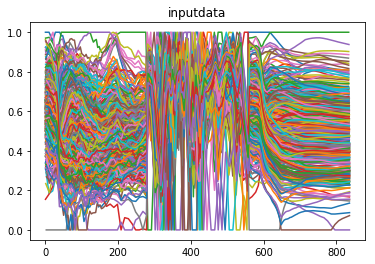

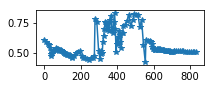

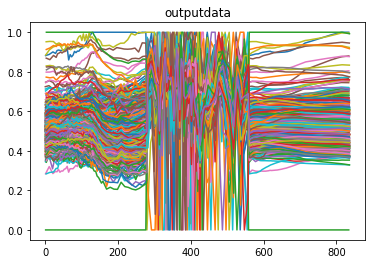

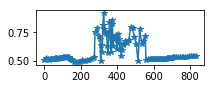

In [16]:
print(np.sum(np.isnan(datain[:])))
print(np.sum(np.isnan(dataout[:])))

plt.plot(time_data_in.T,datain.T)
plt.title('inputdata')
plt.show()

tvec = time_data_in[1,:]
dt = np.median(datain,axis=0)
plt.figure(figsize=(3,1))
plt.plot(tvec,dt,'-*')
plt.show()

plt.plot(time_data_out.T,dataout.T)
plt.title('outputdata')
plt.show()

tvec = time_data_out[1,:]
dt = np.median(dataout,axis=0)
plt.figure(figsize=(3,1))
plt.plot(tvec,dt,'-*')
plt.show()

In [19]:
##########################################################################################
def eigcut(evals,evecs,eps,cut):   
    eigen_val_in = np.exp(np.log(evals)/np.median(eps))
    eidx = np.where(eigen_val_in>cut)
    
    ff = eidx[0]
    if len(ff)<4:
        ff = [0,1,2,3,4,5]
#     plt.semilogy(eigen_val_in[0::],'r')
#     plt.show()
#     print(eidx)
#     ppo
    return ff
        
def inoutdmap(datain,dataout,epsfactin,epsfactout):
    import sklearn.metrics as sm
    data = datain.copy()
    dist_true = sm.pairwise_distances(data,metric = 'euclidean')
    meddist_in = np.median(dist_true)
    print('meddist_in',meddist_in)

    data = dataout.copy()
    dist_true = sm.pairwise_distances(data,metric = 'euclidean')
    meddist_out = np.median(dist_true)
    print('meddist_out',meddist_out)
    print(dist_true.shape)
    ein = {}
    eout ={}
    numcut = {}
    numcutsmad={}
    numcutsnail={}
    
    
    data_type = "compute dmatrix"
    n_evecs = 30
    LB_flag = 1
    state_dependent_eps = True
    cutoff_num=-1
    estimate_eps = False
    verbose=False
    for i in range(0,len(epsfactin)):
    
    
        epsf = epsfactin[i].copy()
        data = datain.copy()
#         epsilon = meddist_in*epsf
        epsilon = epsf
    
        # get input data dmaps
        evecs_in,evals_in,_,_,_,eps_in  = dmap_sp(data,epsilon,
                                            n_evecs,LB_flag,data_type,
                                            estimate_eps=estimate_eps,
                                            cutoff_num=cutoff_num,
                                            state_dependent_eps=state_dependent_eps,verbose=verbose)


        data = dataout.copy()
#         epsilon = meddist_out*epsf
        epsilon = epsfactout[i].copy()

        # get output data dmaps
        evecs_out,evals_out,_,_,_,eps_out = dmap_sp(data,epsilon,
                                            n_evecs,LB_flag,data_type,
                                            estimate_eps=estimate_eps,
                                            cutoff_num=cutoff_num,
                                            state_dependent_eps=state_dependent_eps,verbose=verbose)


        cut_in = (1*(10**(-18)))
        eidx = eigcut(evals_in,evecs_in,eps_in,cut_in)
        ein[i] = [evecs_in[:,eidx],evals_in[eidx],eps_in[eidx],1]
        numcutsmad[i] = (evecs_in[:,eidx]).shape[1]
        
        eidx = eigcut(evals_out,evecs_out,eps_out,cut_in)
        eout[i] = [evecs_out[:,eidx],evals_out[eidx],eps_out[eidx],1]
        numcutsnail[i] = (evecs_out[:,eidx]).shape[1]
        
#         ein[i] = [evecs_in,evals_in,eps_in,1]
#         eout[i] = [evecs_out,evals_out,eps_out,1]
#         numcutsmad[i] = (evecs_in).shape[1]
#         numcutsnail[i] = (evecs_out).shape[1]

        print('i=', str(i),end=" ")
    print('done')  
    numcut['smad']=numcutsmad
    numcut['snail']=numcutsnail
    return eout,ein,numcut 

In [20]:
# import importlib
importlib.reload(dmap_sp_chrisNEW)
num_eps=40

emin,emax = epsminmax(datain)
epsfactin = np.logspace(np.log10(emin/1.2),np.log10(emax*4),num_eps)
emin,emax = epsminmax(dataout)
epsfactout = np.logspace(np.log10(emin/1.2),np.log10(emax*4),num_eps)
# epsfactin = np.sort(np.hstack((epsfactin,0.23263767063348123)))
eout,ein,numcut = inoutdmap(datain,dataout,epsfactin,epsfactout)


# epsfactout = np.sort(np.hstack((epsfactout,0.7561109439140727)))
# eout,toss,epsfact,numcut = inoutdmap(dataout,dataout,epsfactout)

dmin= 2.5609077594516365
dmax= 8.91308941762425
eps_min= 0.28482111572658214
eps_max= 3.4501727301320115
dmin= 3.6951796243828907
dmax= 9.614934090216337
eps_min= 0.5930009925800293
eps_max= 4.014920353670653
meddist_in 1.955575006005966
meddist_out 1.2579728877620122
(425, 425)
i= 0 i= 1 i= 2 i= 3 i= 4 i= 5 i= 6 i= 7 i= 8 i= 9 i= 10 i= 11 i= 12 i= 13 i= 14 i= 15 i= 16 i= 17 i= 18 i= 19 i= 20 i= 21 i= 22 i= 23 i= 24 i= 25 i= 26 i= 27 i= 28 i= 29 i= 30 i= 31 i= 32 i= 33 i= 34 i= 35 i= 36 i= 37 i= 38 i= 39 done


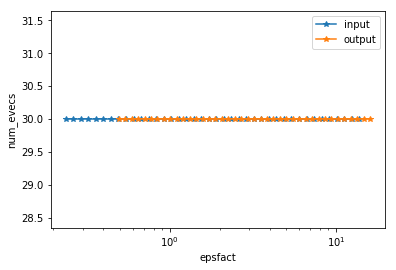

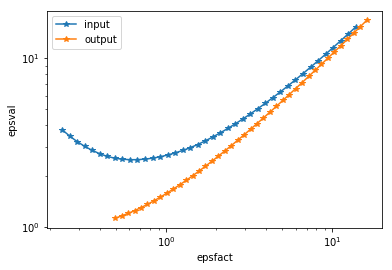

In [21]:
plt.semilogx(epsfactin,numcut['smad'].values(),'-*')
plt.semilogx(epsfactout,numcut['snail'].values(),'-*')
plt.xlabel('epsfact')
plt.ylabel('num_evecs')
plt.legend(['input','output'])
plt.show()

epsz = [eout[x] for x in range(len(eout))]
epsz2 = [np.median((epsz[x])[2]) for x in range(len(epsz))]

epszi = [ein[x] for x in range(len(ein))]
epszi2 = [np.median((epszi[x])[2]) for x in range(len(epszi))]

plt.loglog(epsfactin,epszi2,'-*')
plt.loglog(epsfactout,epsz2,'-*')
plt.xlabel('epsfact')
plt.ylabel('epsval')
plt.legend(['input','output'])
plt.show()
# epsfact = np.logspace(np.log10(0.005),np.log10(6),num_eps)
# eout,toss,epsfact,numcut = inoutdmap(datain,dataout,epsfact)
# plt.plot(numcut.values())
# plt.show()

# make sure you get the same result from algorithm and from non-algorithm DMAP_SP first!
see Dparams/DParamsFinal_v3/usingSameEpsilon_IgetsameEVECS_IN-and-EV_IN in algorithm or in plain DMAP_SP.ipynb for verification of this


In [28]:
#try a new method where you compute dimensionality using LLR (local linear regression)
import GPy

##########################################################################################
def eigcut(evals,evecs,eps,cut):   
    eigen_val_in = np.exp(np.log(evals)/np.median(eps))
    eidx = np.where(eigen_val_in>cut)
    
    ff = eidx[0]
    if len(ff)<4:
        ff = [0,1,2,3,4,5]
#     plt.semilogy(eigen_val_in[0::],'r')
#     plt.show()
#     print(eidx)
#     ppo
    return ff
        
def initaccstro(ndims,euse):
    accL = {}
    for ijk in range(0,ndims):
        accL[ijk] = {}
    for ajk in range(0,len(eout)):
        for v in range(0,ndims):
            accstri = accL[v]
            accstri[ajk] = np.array([0,0])
            accL[v]=accstri
    
    return accL


def Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr):
    kerndim = X.shape[1]
    ker = GPy.kern.Matern52(kerndim,ARD=True) + GPy.kern.White(kerndim)

    # create simple GP model
    m = GPy.models.GPRegression(X,Y,ker)

    # optimize and plot
    m.optimize(messages=messages,max_f_eval = max_f_eval)
    return m
    
def Gpy_mse_plot(m,X,Y,inputstr,outputstr,ploton):
    xp,xstd = m.predict(X)

    
    x1,y1, mse, mseeach = msefunc(xp,Y)
    if ploton==True:
        for i in range(0,x1.shape[1]):
            fig = plt.figure(figsize=(2,2))
            plt.scatter(x1[:,i],y1[:,i],c='k',marker='.')
            plt.xlabel('orig.' + outputstr)
            plt.ylabel('pred.' + outputstr)
            plt.title('predict ' + outputstr + ' based on ' + inputstr + ', rescaled')
            plt.show()
            print('rescaled mse = ',mse)
            print(mseeach.values())
#     print(mseeach)    
    mseeach2 = np.nanmedian(np.array(list(mseeach.values())))
    mseeach3 = np.nansum(np.array(list(mseeach.values())))
    mseeach4 = np.nanmin(np.array(list(mseeach.values())))
    return mseeach2,  mseeach3, mseeach4

def msefunc(xp,Y):
    mseeach={}
    Yscale = np.zeros(Y.shape)
    xpscale = np.zeros(Y.shape)
    for i in range(0,Y.shape[1]):
        Yscale[:,i] = (Y[:,i]-np.mean(Y[:,i]))/np.std(Y[:,i])
        xpscale[:,i] = (xp[:,i]-np.mean(xp[:,i]))/np.std(xp[:,i])
        mseeach[i]=np.mean((Yscale[:,i]-xpscale[:,i])**2)
    scalex = xpscale
    scaley = Yscale
    mse = np.mean((Yscale-xpscale)**2)
    return scalex,scaley, mse, mseeach




def accmultidim9(datatest,eout,smadsnail,ndims,promval):
    # from dmap_sp_chrisNEW import compute_residualsNEW
    import dmap_sp_chrisNEW
    import importlib
    import GPy
    
    importlib.reload(dmap_sp_chrisNEW)

    k=5
    ev_i = [0,1]
    seedval =16
#     accvalo = np.zeros((len(eout)))
    dimaccval = np.zeros((ndims,len(eout)))
    
    #initialize
    dimstringall = initaccstro(ndims,eout)
    dimstring1 = initaccstro(ndims,eout)
    dimstring2 = initaccstro(ndims,eout)

    for a in range(len(eout)):
        evecs_in = eout[a][0]
        evals_in = eout[a][1]
        eps_in = eout[a][2]

        #accuracy in 3 dimensions
        evecs_test = shaver(evecs_in,evals_in,eps_in)
        print('a=',a,' /', np.sum(np.isinf(np.abs(evecs_test[:])))==0)
        if np.sum(np.isinf(np.abs(evecs_test[:])))==0:
            
            msekeeper={}
            ressy1 = np.zeros((evecs_in.shape[1]))
            evs0 = evecs_in.shape[0]
            subsampsize = np.min((evs0,50))# define a subsampling option
            sampiter=20
            rrr1 = np.zeros((sampiter,evecs_in.shape[1]))
            for si in range(sampiter):
                subsamp = numpy.random.randint(0, high=evs0, size=subsampsize, dtype='l')
                rrr0 = compute_residualsNEW(evecs_in[subsamp,:], eps_scale=3, progressBar=True, skipFirst=True, bandwidth_type='median')
                rrr1[si,:] = np.asarray(list(rrr0['Residuals'])).reshape(-1,)
            rrr = np.median(rrr1,axis=0)
            
#             plt.plot(rrr1.T)
#             plt.show()
#             plt.plot(rrr)
#             plt.show()
            
            
#             rrr0 = compute_residualsNEW(evecs_in, eps_scale=3, progressBar=True, skipFirst=True, bandwidth_type='median')
#             rrr = rrr0['Residuals']
#             plt.plot(rrr)
#             plt.show()
#             kill = lop
#             chosenimensiontuple = np.where(rrr>0.1)
            chosenimensiontuple,properties = scipy.signal.find_peaks(rrr, height=None, threshold=None, distance=None, prominence=promval, width=None, wlen=None, rel_height=0.5, plateau_size=None)

#             print(accstr2M[0])
            chosenimensions = [np.asarray(chosenimensiontuple).reshape(-1,)]
    
            bestdimsdescent = np.argsort(rrr)
            bestdimsall = bestdimsdescent[::-1]

            #use Smad Manifold to predicut Smad trajectories (1 timepoint)
            # sample inputs and outputs
            inputstr = 'smad dmaps'
            outputstr = 'median'
            X = evecs_in[:,chosenimensions[0]]
            
            max_f_eval = 1000
            messages=False
            Yin = datatest.copy()
            Y = Yin
            
            m = Gpymadness(X[subsamp,:],Y[subsamp,:],messages,max_f_eval,inputstr,outputstr)
            mseeach2,mseeach3,mseeach4 = Gpy_mse_plot(m,X,Y,inputstr,outputstr,False)
            outputstr = 'median'
            msekeeper[outputstr]=mseeach2
#             outputstr = 'sum'
#             msekeeper[outputstr]=mseeach3
#             outputstr = 'min'
#             msekeeper[outputstr]=mseeach4

            lk = list(msekeeper.keys())
            v=0
            for v in range(0,np.min([len(lk),len(bestdimsall)])):
                bestdimsub=bestdimsall[0:(v+1)]
                print(lk[v])
#                 msekeeper[lk[v]]
                accval = np.array(msekeeper[lk[v]]).sum()
                dimaccval[v,a]=accval
                
                #store the dimensions in order of importance (as determined by LLR)
                accstri0 = dimstringall[v]
                accstri0[a] = bestdimsub
                dimstringall[v]=accstri0
                
                #store the residuals (as determined by LLR)
                accstri1 = dimstring1[v]
                accstri1[a] = rrr
                dimstring1[v]=accstri1

                
                #store the good dimensions (as determined by LLR res>cut)
                accstri2 = dimstring2[v]
                accstri2[a] = chosenimensions[0]
                dimstring2[v] = accstri2
                print(chosenimensions[0])

    print('done')
    return dimaccval,dimstringall,dimstring1,dimstring2


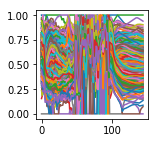

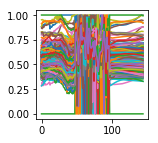

In [29]:
plt.figure(figsize=(2,2))
plt.plot(observed_data_in.T)
plt.show()

plt.figure(figsize=(2,2))
plt.plot(observed_data_out.T)
plt.show()

In [30]:
def removeAllzerotpoints(data):
    for k in range(0,data.shape[1]):
        if np.std(data[:,k])>1e-14:
            nl=1
#             print(k,',',end="")
#             data[:,k] = data[:,k] - np.min(data[:,k])
#             data[:,k] = data[:,k] / np.max(data[:,k])
#             #observed_data_out[:,k] = np.log(observed_data_out[:,k]+1e-0)
#             data[:,k] = np.sqrt(data[:,k])
        else:
            data[:,k] = np.nan
    
    nansum = np.sum(np.isnan(data),axis=0)
#     print(nansum.shape)
    nonanloc = np.where(nansum==0)[0]
    data=data[:,nonanloc]
    
    return data

(425, 144)


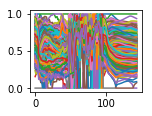

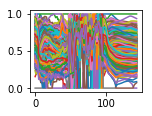

In [31]:
testout = removeAllzerotpoints(observed_data_in.copy())
print(testout.shape)
plt.figure(figsize=(2,1.5))
plt.plot(testout.T)
plt.show()
plt.figure(figsize=(2,1.5))
plt.plot(observed_data_in.T)
plt.show()


In [32]:
print(observed_data_in.shape)
def reducedimensionalityforGPy(observed_data_in):
    if observed_data_in.shape[1]>50:
        uclresampz = np.unique(np.ceil(np.linspace(1,observed_data_in.shape[1]-1,50)))
        uclresamp = [int(x) for x in list(uclresampz)]
        observed_data_in = observed_data_in[:,uclresamp]
#         print(observed_data_in.shape)
    return observed_data_in.copy()

datatest = removeAllzerotpoints(reducedimensionalityforGPy(observed_data_in))
print(datatest.shape)

(425, 144)
(425, 50)


In [33]:
seedval=2
ndims=4
smadsnail = 'smad'
datatest = removeAllzerotpoints(reducedimensionalityforGPy(observed_data_in))
euse = ein.copy()
promval = 0.05
accvali2,accstri20,accstri21,accstri22= accmultidim9(datatest,euse,smadsnail,ndims,promval)


a= 0  / True
median
[ 1  4  6 12]
a= 1  / True
median
[ 1  4  6 11]
a= 2  / True
median
[ 1  4  6 10]
a= 3  / True
median
[ 1  4 10]
a= 4  / True
median
[1 4 9]
a= 5  / True
median
[1 4 9]
a= 6  / True
median
[1 4 9]
a= 7  / True
median
[1 4 9]
a= 8  / True
median
[1 4 9]
a= 9  / True
median
[1 4 9]
a= 10  / True
median
[1 4 9]
a= 11  / True
median
[1 4 9]
a= 12  / True
median
[1 4 9]
a= 13  / True
median
[1 4 9]
a= 14  / True
median
[1 4 9]
a= 15  / True
median
[1 4 9]
a= 16  / True
median
[1 4 9]
a= 17  / True
median
[1 4 9]
a= 18  / True
median
[1 4 9]
a= 19  / True
median
[1 4 9]
a= 20  / True
median
[1 4 6 9]
a= 21  / True
median
[1 3 6 9]
a= 22  / True
median
[ 1  3  6 10]
a= 23  / True
median
[ 1  3  6 10]
a= 24  / True
median
[1 3 6]
a= 25  / True
median
[1 3 6]
a= 26  / True
median
[1 3 7]
a= 27  / True
median
[1 3 7]
a= 28  / True
median
[1 3 7]
a= 29  / True
median
[1 3 8]
a= 30  / True
median
[ 1  3 10]
a= 31  / True
median
[ 1  3 13]
a= 32  / True
median
[1 3]
a= 33  / Tru

In [34]:
smadsnail = 'snail'
datatest = removeAllzerotpoints(reducedimensionalityforGPy(observed_data_out))
euse = eout.copy()
promval=0.05
accvalo2,accstro20,accstro21,accstro22 = accmultidim9(datatest,euse,smadsnail,ndims,promval)

a= 0  / True
median
[1 9]
a= 1  / True
median
[1 9]
a= 2  / True
median
[1 9]
a= 3  / True
median
[1 7 9]
a= 4  / True
median
[1 7 9]
a= 5  / True
median
[1 7 9]
a= 6  / True
median
[1 9]
a= 7  / True
median
[1 9]
a= 8  / True
median
[1 9]
a= 9  / True
median
[1 9]
a= 10  / True
median
[1 9]
a= 11  / True
median
[1 9]
a= 12  / True
median
[1 9]
a= 13  / True
median
[1 9]
a= 14  / True
median
[1 9]
a= 15  / True
median
[1 9]
a= 16  / True
median
[1 9]
a= 17  / True
median
[1 8]
a= 18  / True
median
[1 8]
a= 19  / True
median
[1 7]
a= 20  / True
median
[1]
a= 21  / True
median
[1]
a= 22  / True
median
[1]
a= 23  / True
median
[1]
a= 24  / True
median
[1]
a= 25  / True
median
[1]
a= 26  / True
median
[1]
a= 27  / True
median
[1]
a= 28  / True
median
[1]
a= 29  / True
median
[1 3]
a= 30  / True
median
[1 4]
a= 31  / True
median
[1 4]
a= 32  / True
median
[1 4 6]
a= 33  / True
median
[1 4 8]
a= 34  / True
median
[1 4 8]
a= 35  / True
median
[1 4]
a= 36  / True
median
[1 4]
a= 37  / True
med

In [35]:
session_name = 'sesh_'+str(num_eps)+'smadEPS'+str(num_eps)+'snailEPS'


##########################   EXPORT ########################
import dill as pickle;
from pathlib import Path
# import os

# cwd = Path().resolve()
# print(cwd)
# repo = str(cwd) +'/'

session_savepath = 'session' + conditionid + specid + 'clean/'
session_path = repo + session_savepath

print(not (os.path.isdir(session_path)))
if not (os.path.isdir(session_path)):
    print('making' + session_path + '...')
    os.mkdir(session_path)


savename = session_path + session_name

pickle.dump_session(savename)
print('pickle success!!!')

# ########################  IMPORT   ############################
# import dill as pickle;
# from pathlib import Path

# cwd = Path().resolve()
# print(cwd)
# repo = str(cwd) +'/'

# session_savepath = 'session' + conditionid + specid + 'clean/'
# session_path = repo + session_savepath
# savename = session_path + session_name


# pickle.load_session(savename)
# print(ev_in)

True
making/Users/frick/Dparams/DParamsFinal_v4/sessionexp3mdl_S3conc_CAGAconc_gpy_-DIFF-positive_LLRpeakfinder_CLEAN-AGNOSTIC-ztosqrtResampleCAGAclean/...
pickle success!!!


In [36]:


def plotaccmultidim7(accy,euse,acclab,ndims,smadsnail,epsfact):
    fontsize = 14
    labelsv0 = list(acclab[0].values())
    labelsv  = [labelsv0[x] for x in range(0,len(labelsv0))]
    dimlist = [len(x) for x in labelsv]
    ndims = np.max(dimlist)
    ndimsmin = np.min(dimlist)
    accy0 = accy[0].reshape(-1,)
    legstr={}
    fig = plt.figure(figsize=(9,3))
    for v in range(ndimsmin-1,ndims):
        idx = np.where(np.asarray(dimlist).reshape(-1,) == v+1)[0]
        legstr[v] = str(v+1)+' dim'
#         labelsv0 = list(acclab[v].values())
#         labelsv  = [labelsv0[x] for x in idx]
        
        plt.semilogy(idx+(0.01*v),accy0[idx],'o')
    plt.xticks(ticks=range(0,len(accy0[:])), labels=labelsv, rotation=90)
    plt.xlabel('DMAP dims',fontsize=fontsize)
    plt.ylabel('mse of data prediction',fontsize=fontsize)
    plt.title('assessing dimensionality and quality of '+smadsnail + ' dmaps for varying epsilons')
    plt.ylim(np.min(accy0[:]),np.max((np.max(accy0[:]),1)))
    plt.legend(list(legstr.values()))    
    plt.show()
    
    fig = plt.figure(figsize=(9,3))
    legstr={}
    ra = range(accy.shape[0])
    for vi in ra[0::]:
#         eppx = [np.median(euse[i][2]) for i in range(0,len(euse))]
        plt.loglog(epsfact,accy[vi,:],'o-')
#         legstr[vi] = [str(vi+1)+'dim']

    plt.legend(['median'])
    # plt.xticks(ticks=range(0,len(accval4)), labels=accstr4.values(), rotation=90)
    plt.xlabel('epsilon',fontsize=fontsize)
    plt.ylabel('mse of data prediction',fontsize=fontsize)
    plt.title('assessing dimensionality and quality of '+smadsnail + ' dmaps for varying epsilons')
    plt.ylim(np.min(accy[:]),np.max((np.max(accy[:]),1)))
    plt.show()

    
    fig = plt.figure(figsize=(9,3))
    legstr={}
    ra = range(accy.shape[0])
    for vi in ra[0::]:
        eppx = [np.median(euse[i][2]) for i in range(0,len(euse))]
        plt.loglog(eppx,accy[vi,:],'*-')
#         legstr[vi] = [str(vi+1)+'dim']

    plt.legend(['median'])
    # plt.xticks(ticks=range(0,len(accval4)), labels=accstr4.values(), rotation=90)
    plt.xlabel('epsilon',fontsize=fontsize)
    plt.ylabel('mse of data prediction',fontsize=fontsize)
#     plt.title(smadsnail + ' accuracy',fontsize=fontsize)
    plt.title('assessing dimensionality and quality of '+smadsnail + ' dmaps for varying epsilons')
    plt.ylim(np.min(accy[:]),np.max((np.max(accy[:]),1)))
    plt.show()
    

 /Users/frick/anaconda/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


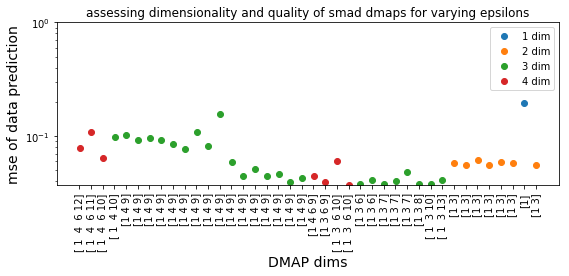

 /Users/frick/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


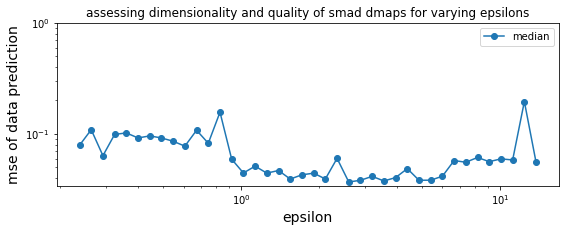

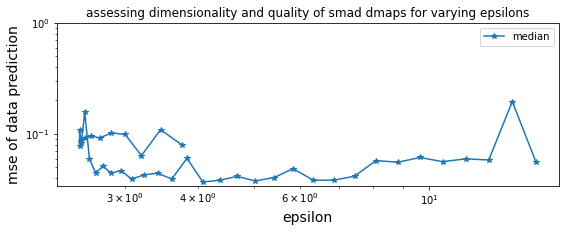

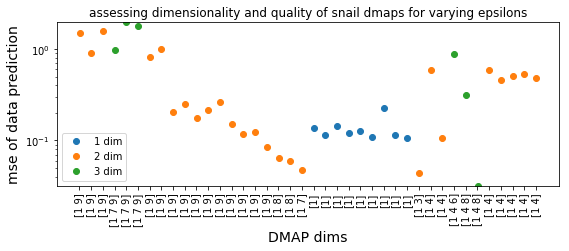

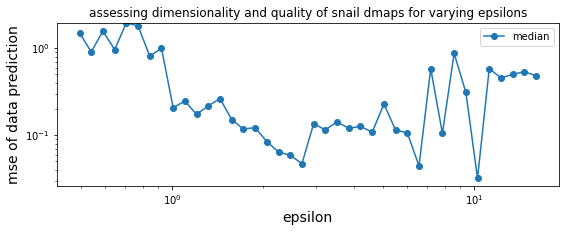

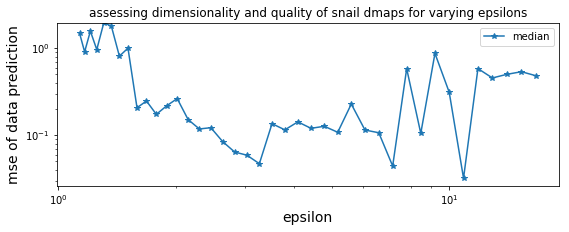

In [37]:
accy = accvali2.copy()
euse = ein.copy()
acclab = accstri22.copy()
smadsnail = 'smad'
plotaccmultidim7(accy,euse,acclab,ndims,smadsnail,epsfactin)

accy = accvalo2.copy()
euse = eout.copy()
acclab = accstro22.copy()
smadsnail = 'snail'
plotaccmultidim7(accy,euse,acclab,ndims,smadsnail,epsfactout)


In [38]:

def manifoldgrabber(acclab,euse,smadsnail,accy,accvals,accuracycutoff):
    acl = acclab[0]
    acllist = list(acl.values())
    dimlist = [len(x) for x in acllist]
    ndims = np.max(dimlist)
    ndimsmin = np.min(dimlist)
    accy0 = accy[0].reshape(-1,)
    accuracyForGivenDimensions={}
    for v in range(ndimsmin-1,ndims):
        idx = np.where(np.asarray(dimlist).reshape(-1,) == v+1)[0]
        if len(idx)>0:
            bestones = [np.argmin(accvals[idx])]
            accuracyForGivenDimensions['dim'+str(v+1)+'accvals'] =accvals[idx]
            accuracyForGivenDimensions['dim'+str(v+1)+'indices'] = idx
            accuracyForGivenDimensions['dim'+str(v+1)+'best'] = idx[bestones]
            accuracyForGivenDimensions['dim'+str(v+1)+'dmap dims'] = acllist[(idx[bestones])[0]]

    for v in range(ndimsmin-1,ndims):
        idx = np.where(np.asarray(dimlist).reshape(-1,) == v+1)[0]
        if len(idx)>0:
            bestone = np.sort(accvals[idx])
            if bestone[0]<accuracycutoff:
                print('break at dim = ' + str(v+1))
                break


    print('minimum dimensionality = ' +str(v+1)+ 'dimensional') 
    print('accuracies of manifolds ',accuracyForGivenDimensions['dim'+str(v+1)+'accvals'])
    print('index of best manifold ', accuracyForGivenDimensions['dim'+str(v+1)+'best'])
    print('epsilon of best manifold ', epsfactout[accuracyForGivenDimensions['dim'+str(v+1)+'best']])
    print('accurcy of best manifold ', accuracyForGivenDimensions['dim'+str(v+1)+'dmap dims'])
    euseindex = accuracyForGivenDimensions['dim'+str(v+1)+'best']
    ev_chosen = accuracyForGivenDimensions['dim'+str(v+1)+'dmap dims']
    
    return euseindex,ev_chosen


In [87]:
# now find a a low dimensional manifold that gives a great prediction. 
accy = accvali2.copy()
euse = ein.copy()
acclab = accstri22.copy()
smadsnail = 'smad'

accvals = accy[0]
accuracycutoff = np.max((np.min(accvals)*1.05,1e-3))
print(smadsnail)
print('accuracycutoff = ', str(accuracycutoff))
e_in_index,ev_in = manifoldgrabber(acclab,euse,smadsnail,accy,accvals,accuracycutoff)

print('')
print('')

accy = accvalo2.copy()
euse = eout.copy()
acclab = accstro22.copy()
smadsnail = 'snail'

print(smadsnail)
accvals = accy[0]
accuracycutoff = np.max((np.min(accvals)*1.05,1e-3))
# accuracycutoff = np.max((np.min(accvals)*1.05,1e-3))
print('accuracycutoff = ', str(accuracycutoff))
e_out_index,ev_out = manifoldgrabber(acclab,euse,smadsnail,accy,accvals,accuracycutoff)



smad
accuracycutoff =  0.038720092898790685
break at dim = 3
minimum dimensionality = 3dimensional
accuracies of manifolds  [0.09891325 0.10205328 0.09193595 0.09594233 0.09192263 0.08586075
 0.07755291 0.1078528  0.08239531 0.15682986 0.05914416 0.04444497
 0.05119995 0.04430386 0.04679303 0.0391886  0.04278232 0.03819235
 0.04143083 0.03768338 0.04037621 0.04864573 0.03820428 0.03827876
 0.04156594]
index of best manifold  [26]
epsilon of best manifold  [5.03248716]
accurcy of best manifold  [1 3 7]


snail
accuracycutoff =  0.03364669649860617
break at dim = 3
minimum dimensionality = 3dimensional
accuracies of manifolds  [0.96638231 1.95801091 1.80593305 0.87393395 0.31245961 0.03204447]
index of best manifold  [34]
epsilon of best manifold  [10.27799419]
accurcy of best manifold  [1 4 8]


In [40]:
a = int(e_in_index)
print('a',a)
einsub = ein[a]
evecs_in = einsub[0]
evals_in = einsub[1]
eps_in = einsub[2]


b = int(e_out_index)
print('b',b)
eoutsub = eout[b]
evecs_out = eoutsub[0]
evals_out = eoutsub[1]
eps_out = eoutsub[2]

print('ev_in',ev_in)
print('ev_out',ev_out)
print('evecs_in',evecs_in.shape)
print('evals_in',evals_in.shape)
print('eps_in',eps_in.shape)
print('evecs_out',evecs_out.shape)
print('evals_out',evals_out.shape)
print('eps_out',eps_out.shape)

a 26
b 34
ev_in [1 3 7]
ev_out [1 4 8]
evecs_in (425, 30)
evals_in (30,)
eps_in (30,)
evecs_out (425, 30)
evals_out (30,)
eps_out (30,)


In [41]:
# eminevec,emaxevec = epsminmax(evecs_in)
# print(eminevec)
# print(emaxevec)

# eminevecout,emaxevecout = epsminmax(evecs_out)
# print(eminevecout)
# print(emaxevecout)

In [42]:
# from dmap_sp_chrisNEW import compute_residualsNEW
import dmap_sp_chrisNEW
import importlib
importlib.reload(dmap_sp_chrisNEW)
from dmap_sp_chrisNEW import compute_residualsNEW
scalevec = np.logspace(np.log10(1.5),np.log10(6),3)
# scalevec=[3]

def runLLR(evecs_in):
    idx = np.asarray(range(0,np.min((evecs_in.shape[1],30)))).reshape(-1,)
    evecs_test = evecs_in[:,idx].copy()

    print('evecs_shape',evecs_test.shape)
    rrr = np.zeros(evecs_test.shape[1])
    print(evecs_test.shape[1])
    ressy1 = np.zeros((len(scalevec),evecs_test.shape[1]))
    cycle=int(-1)

    for i in scalevec:
        cycle=cycle+1
#         rrr0 = compute_residualsNEW(evecs_test, eps_scale=i, progressBar=True, skipFirst=True, bandwidth_type='median')
#         rrr = rrr0['Residuals']
#         ressy1[int(cycle),0:(evecs_test.shape[1])]=rrr
        evs0 = evecs_test.shape[0]
        subsampsize = np.min((evs0,50))# define a subsampling option
        sampiter=10
        rrr1 = np.zeros((sampiter,evecs_test.shape[1]))
        for si in range(sampiter):
            subsamp = numpy.random.randint(0, high=evs0, size=subsampsize, dtype='l')
            rrr0 = compute_residualsNEW(evecs_test[subsamp,:], eps_scale=i, progressBar=True, skipFirst=True, bandwidth_type='median')
            rrr1[si,:] = np.asarray(list(rrr0['Residuals'])).reshape(-1,)
        rrr = np.median(rrr1,axis=0)
        ressy1[int(cycle),0:(evecs_test.shape[1])]=rrr
        print(cycle,end=" ")
    print('done')
    return ressy1,scalevec

In [43]:
ressy1,scalevec = runLLR(evecs_in.copy())
ressy2,scalevec = runLLR(evecs_out.copy())

evecs_shape (425, 30)
30
0 1 2 done
evecs_shape (425, 30)
30
0 1 2 done


In [44]:
def runLLRsubsamp(evecs_in):
    idx = np.asarray(range(0,np.min((evecs_in.shape[1],30)))).reshape(-1,)
    evecs_test = evecs_in[:,idx].copy()
    evs = evecs_test.shape[0]

    plt.figure(figsize=(8,3))
    for i in range(0,1):
        sampsize=evs
        subsamp = numpy.random.randint(0, high=evs, size=sampsize, dtype='l')
        rrr0 = compute_residualsNEW(evecs_test[subsamp,:], eps_scale=3, progressBar=True, skipFirst=True, bandwidth_type='median')
        rrr = rrr0['Residuals']
        plt.plot(rrr,'k-',linewidth=2)
        
    for i in range(0,5):
        sampsize=100
        subsamp = numpy.random.randint(0, high=evs, size=sampsize, dtype='l')
        rrr0 = compute_residualsNEW(evecs_test[subsamp,:], eps_scale=3, progressBar=True, skipFirst=True, bandwidth_type='median')
        rrr = rrr0['Residuals']
        plt.plot(np.asarray(range(len(rrr))).reshape(-1,)+(i/50),rrr,'r-',linewidth=0.5)
        
        
    for i in range(0,5):
        sampsize=50
        subsamp = numpy.random.randint(0, high=evs, size=sampsize, dtype='l')
        rrr0 = compute_residualsNEW(evecs_test[subsamp,:], eps_scale=3, progressBar=True, skipFirst=True, bandwidth_type='median')
        rrr = rrr0['Residuals']
        plt.plot(np.asarray(range(len(rrr))).reshape(-1,)+(i/100),rrr,'b-',linewidth=0.5)
        
    plt.legend(['500','100','50'])
    plt.show()
    peaks,properties = scipy.signal.find_peaks(rrr, height=None, threshold=None, distance=None, prominence=0.1, width=None, wlen=None, rel_height=0.5, plateau_size=None)
    print(peaks)
    print(properties)
    print('done')

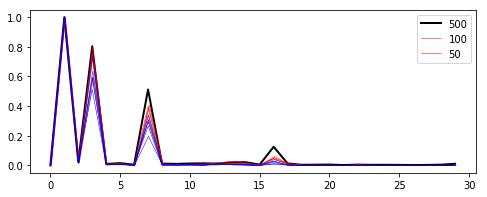

[1 3 7]
{'prominences': array([0.99998093, 0.62447427, 0.30856988]), 'left_bases': array([0, 2, 6]), 'right_bases': array([27, 27, 27])}
done


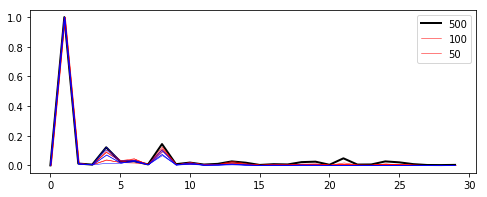

[1]
{'prominences': array([0.99999737]), 'left_bases': array([0]), 'right_bases': array([29])}
done


In [45]:
runLLRsubsamp(evecs_in.copy())
runLLRsubsamp(evecs_out.copy())

In [46]:
def plotLLRresRK(ressy1,smadsnail,scalevec,promval):
    
    from matplotlib import rc
    rc('text', usetex=False)
    #eps_scale of 3 , cutoff of 0.05
    #eps_scale of 6 is best when more n_evecs are considered
    cycle=int(-1)
    for i in scalevec:
        cycle=cycle+1
        rrr = ressy1[int(cycle),:]
        chosenimensiontuple,properties = scipy.signal.find_peaks(rrr, height=None, threshold=None, distance=None, prominence=promval, width=None, wlen=None, rel_height=0.5, plateau_size=None)
        chosenimensions = np.asarray(chosenimensiontuple).reshape(-1,)
        plt.figure(figsize=(4,1.5))
        plt.plot(rrr)
        ridx = chosenimensions
        x = np.linspace(0,len(rrr)-1,len(rrr))

        plt.plot(x[ridx],rrr[ridx],'ro')
        plt.title('Local Linear Regression, '+smadsnail+' , eps_scale=' + str(np.round(i,2)))
#         rridx0 = np.where(ridx==True)
#         print(chosenimensions)
        rridx = list(chosenimensions)
        for h in rridx:
            tx= int(x[h])
            ty = rrr[h]
            ts = str(np.round(ty,2))
            t = plt.text(tx+0.2,ty,tx)
#         print('epsscale,',str(np.round(i,2)),'--rval,', rrr[ridx])
#     print(x[ridx])
    plt.ylabel("$r_k$",fontsize=15)
    plt.xlabel('DMAP dimension',fontsize=12)
    plt.ylim(0,1.2)
    plt.show()

    
    ev_in = x[ridx]
    ev_in = [int(x) for x in ev_in]
    

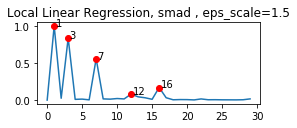

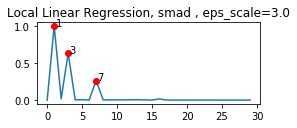

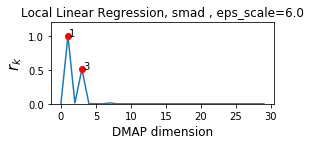

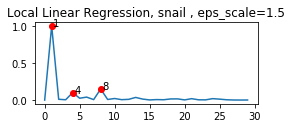

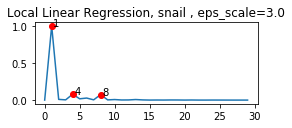

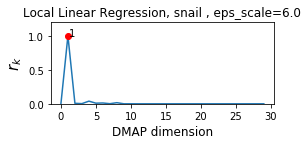

In [47]:
plotLLRresRK(ressy1,'smad',scalevec,promval)
plotLLRresRK(ressy2,'snail',scalevec,promval)

In [48]:
# print(scalevec[3])
peaks,properties = scipy.signal.find_peaks(ressy1[-1,:], height=None, threshold=None, distance=None, prominence=0.1, width=None, wlen=None, rel_height=0.5, plateau_size=None)
# print(peaks)
# print(properties)

In [49]:
#choose important eigenvectors
# ev_in = goodinputs.astype(int).copy() # important eigenvectors for input, determined visually from previous plots
# ev_in = ev_in[2]
# ev_out = goodoutputs.astype(int).copy() # important eigenvectors for output, determined visually from previous plots
# ev_out = ev_out[1]
print("ev_in",ev_in)
print("ev_out",ev_out)

ev_in [1 3 7]
ev_out [1 4 8]


In [50]:
# evecs_out = evecs_out*-1
# evecs_in[:,1] = evecs_in[:,1]*-1
# evecs_in[:,4] = evecs_in[:,4]*-1
# evecs_out = 

In [51]:
#save these as CSV files so you don't have to run it again and again

savepath = str(cwd) + '/' + csvsavepath
print(savepath)
if not os.path.exists(savepath):
    os.makedirs(savepath)

    

a = numpy.asarray(evecs_in)
numpy.savetxt(savepath+"evecs_in.csv", a, delimiter=",")
a = numpy.asarray(evals_in)
numpy.savetxt(savepath+"evals_in.csv", a, delimiter=",")
a = numpy.asarray(ev_in)
numpy.savetxt(savepath+"ev_in.csv", a, delimiter=",")


a = numpy.asarray(evecs_out)
numpy.savetxt(savepath+"evecs_out.csv", a, delimiter=",")
a = numpy.asarray(evals_out)
numpy.savetxt(savepath+"evals_out.csv", a, delimiter=",")
a = numpy.asarray(ev_out)
numpy.savetxt(savepath+"ev_out.csv", a, delimiter=",")

a = numpy.asarray(eps_in)
numpy.savetxt(savepath+"eps_in.csv", a, delimiter=",")
a = numpy.asarray(eps_in)
numpy.savetxt(savepath+"eps_out.csv", a, delimiter=",")

/Users/frick/Dparams/DParamsFinal_v4/_dmap_csv_exp3tcutmdl_S3conc_CAGAconc_gpy_-DIFF-positive_LLRpeakfinder_CLEAN-AGNOSTIC-ztosqrtResampleCAGAclean/


In [52]:
#load the CSV files
savepath = str(cwd) + '/' + csvsavepath

evecs_in_csv = np.genfromtxt(savepath+"evecs_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
evecs_out_csv = np.genfromtxt(savepath+"evecs_out.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

evals_in_csv = np.genfromtxt(savepath+"evals_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
evals_out_csv = np.genfromtxt(savepath+"evals_out.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

eps_in_csv = np.genfromtxt(savepath+"eps_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
eps_out_csv = np.genfromtxt(savepath+"eps_out.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

ev_in_csv = np.genfromtxt(savepath+"ev_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
ev_out_csv = np.genfromtxt(savepath+"ev_out.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

In [53]:
#use this to load the CSV files for determined using SYST1
#if you are running SYST2 then load the SYST1 DMAP
if conditionid == 'expSYST2_PC':
    print('loading OG DMAP')
#     specid2 = 'mdl_S3conc_IFFLconc_gpy_GRAD-DIFF_nonZTOSQRT-positive_msemedian_forfig'
    specid2 = specid
    conditionid2 = 'expSYST1_PC'
    csvsavepath2 = '_dmap_csv_' + conditionid2 + cond2+ specid2 + 'clean/'

    #load the CSV files
    savepath = str(cwd) + '/' + csvsavepath2
    evecs_in_csv = np.genfromtxt(savepath+"evecs_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
    evals_in_csv = np.genfromtxt(savepath+"evals_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
    eps_in_csv = np.genfromtxt(savepath+"eps_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
    ev_in_csv = np.genfromtxt(savepath+"ev_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

In [54]:
evecs_in = evecs_in_csv
evecs_out = evecs_out_csv

evals_in = evals_in_csv
evals_out = evals_out_csv
ev_in = np.asarray(ev_in_csv,dtype='int').reshape(-1,)
ev_out = np.asarray(ev_out_csv,dtype='int').reshape(-1,)

eps_in = eps_in_csv
eps_out = eps_out_csv

In [55]:
print(evecs_out.shape)

(425, 30)


In [56]:
# evecs_in[:,ev_in[0]] = evecs_in[:,ev_in[0]]*-1

(425, 30)
ev_in [1 3 7]
ev_out [1 4 8]
0
1
2
3
0
1
2
3
done


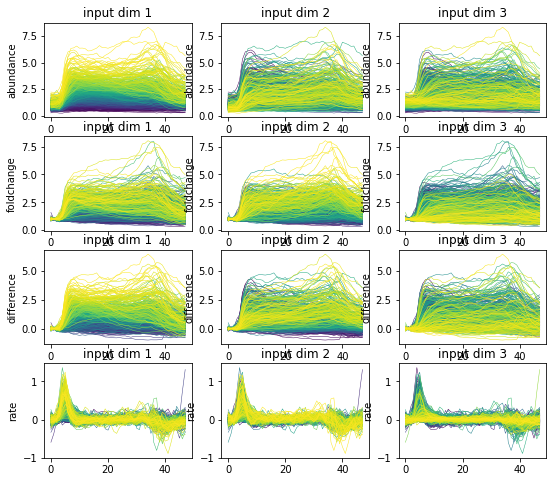

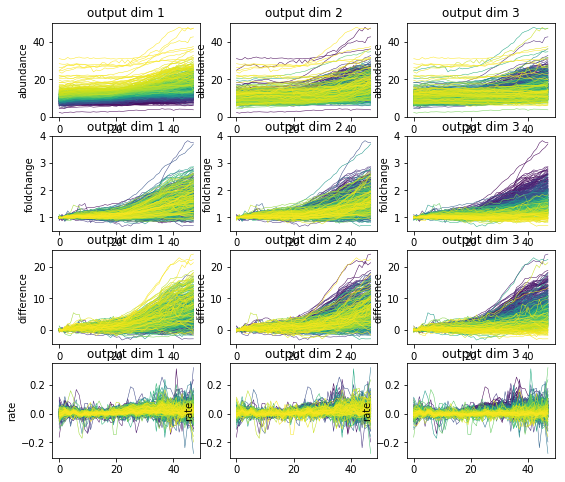

In [57]:
import accessory
importlib.reload(accessory)
# from accessory import plot_trajectories_based_on_dparam
# importlib.reload(accessory)
# from accessory import *
# ev_in = [1,4,11]
# ev_out = [1,7,11]

print(evecs_out.shape)
print('ev_in',ev_in)
print('ev_out',ev_out)
plot_trajectories_based_on_dparam(time_data,ogdin,evecs_in,ev_in,'input')
plot_trajectories_based_on_dparam(time_data,ogdout,evecs_out,ev_out,'output')

# plot_trajectories_based_on_dparam(tvec,traj,evecs_0,ev_0,strstr):
print('done')
# evecs_out[]

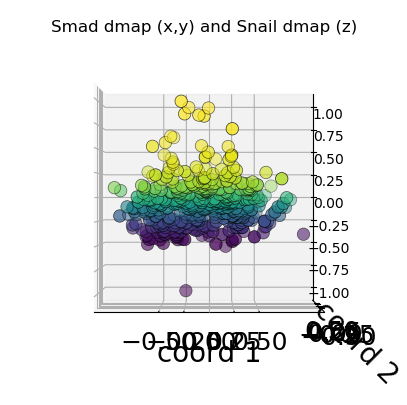

/Users/frick/Dparams/DParamsFinal_v4/2d-manifold_exp3tcut/ snailC 3d man.png
done


In [58]:
savepath = str(cwd) + '/2d-manifold_' +conditionid+cond2+'/'
if not os.path.exists(savepath):
    os.makedirs(savepath)
    
fontsize=20
plt.style.use('default')
# plt.style.use('ggplot')   
fsize = (5,5)
msize = 80
lw = 0.5
cmap = plt.cm.viridis

fig = plt.figure(figsize=fsize)
ax = fig.add_subplot(111, projection='3d')
x = evecs_in[:,ev_in[0]].copy()
y = evecs_in[:,ev_in[1]].copy()
cc = evecs_out[:,ev_out[0]].copy()
z = cc.copy()
csort = np.argsort(cc)
cc = range(len(csort))
# cw = np.where(cc>0)
# cc[cw]=0
# csort = range(len(cc))
xx = x[csort]
yy = y[csort]
zz = z[csort]

xtickvec = np.linspace(-1,1,5)
ax.scatter(xx,yy,zz,c=cc,s=msize,edgecolor='k',linewidths=lw, cmap = cmap)
plt.xlabel('coord 1',fontsize=fontsize)
plt.ylabel('coord 2',fontsize=fontsize)
plt.xticks(np.divide(xtickvec,2),fontsize=fontsize-2)
plt.yticks(np.divide(xtickvec,2),fontsize=fontsize-2)
plt.title('Smad dmap (x,y) and Snail dmap (z)')
savestr = savepath+' snailC 3d man.png'
plt.savefig(savestr,bbox_inches='tight')
ax.view_init(0,-90)
plt.show()

print(savestr)
print('done')

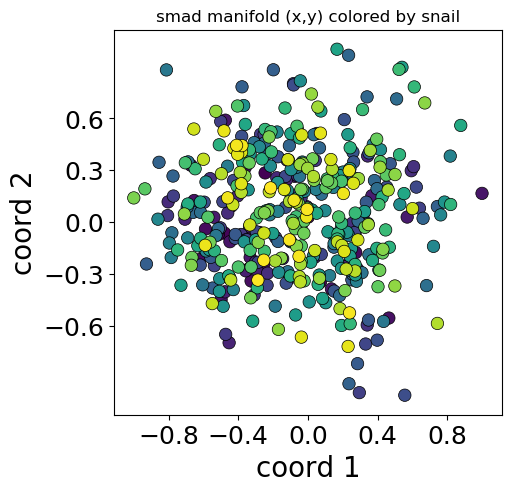

/Users/frick/Dparams/DParamsFinal_v4/2d-manifold_exp3tcut/ smad manifold colored by snail.png
done


In [59]:

fig = plt.figure(figsize=fsize)
ax = fig.add_subplot(111)


ax.scatter(xx,yy,c=cc,s=msize,edgecolor='k',linewidths=lw, cmap = cmap)
plt.xlabel('coord 1',fontsize=fontsize)
plt.ylabel('coord 2',fontsize=fontsize)
plt.title('smad manifold (x,y) colored by snail')

xtickvec= np.linspace(-1.6,1.6,5)
plt.xticks(np.divide(xtickvec,2),fontsize=fontsize-2)
xtickvec= np.linspace(-1.2,1.2,5)
plt.yticks(np.divide(xtickvec,2),fontsize=fontsize-2)
savestr = savepath+' smad manifold colored by snail.png'
plt.savefig(savestr,bbox_inches='tight')

plt.show()

print(savestr)
print('done')

[1 4 8]


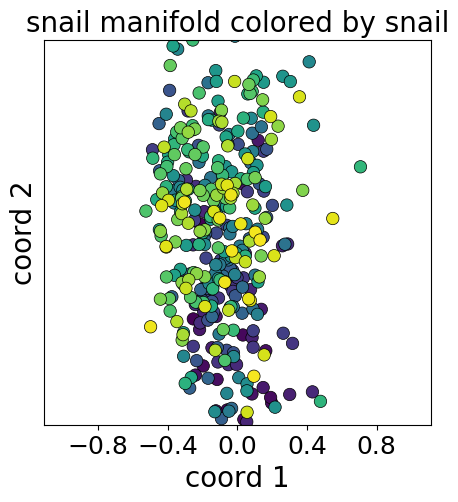

/Users/frick/Dparams/DParamsFinal_v4/2d-manifold_exp3tcut/ Snail manifold colored by snail EXTRA.png
done


In [60]:

fig = plt.figure(figsize=fsize)
ax = fig.add_subplot(111)
print(ev_out)

xlabelstr = 'coord 1'
ylabelstr = 'coord 2'
if len(ev_out)>1:
    x = evecs_out[:,ev_out[0]].copy()
    y = evecs_out[:,ev_out[1]].copy()
else:
    x = np.asarray(range(evecs_out.shape[1])).reshape(-1,)
    y = evecs_out[:,ev_out[0]].copy()
    y = np.sort(y)
    x = np.argsort(y)
    xlabelstr = 'cell index'
    ylabelstr = 'coord 1'
    
if len(ev_out)>2:
    cc = evecs_out[:,ev_out[2]].copy()
    z = cc.copy()
    csort = np.argsort(cc)
    cc = range(len(csort))
    titlestr = 'snail manifold colored by snail'
else:
    cc = np.zeros(y.shape)
    titlestr = 'snail manifold'
    

xx = x[csort]
yy = y[csort]
zz = z[csort]

ax.scatter(xx,yy,c=cc,s=msize,edgecolor='k',linewidths=lw, cmap = cmap)
plt.xlabel(xlabelstr,fontsize=fontsize)
plt.ylabel(ylabelstr,fontsize=fontsize)
plt.title(titlestr,fontsize=fontsize)

if len(ev_out)>1:
    xtickvec= np.linspace(-1.6,1.6,5)
    plt.xticks(np.divide(xtickvec,2),fontsize=fontsize-2)
    xtickvec= np.linspace(-1.2,1.2,5)
    plt.yticks(np.divide(xtickvec,2),fontsize=fontsize-2)

    ym = np.median(y[:])
    yst = np.std(y[:])
    stdf=0.1
    yl = [ym - yst*stdf,ym + yst*stdf]
    plt.ylim(yl)

savestr = savepath+' Snail manifold colored by snail EXTRA.png'
plt.savefig(savestr,bbox_inches='tight')
plt.show()

print(savestr)
print('done')

In [61]:
# whos

In [62]:
import dill as pickle;
from pathlib import Path
# import os

# cwd = Path().resolve()
# print(cwd)
# repo = str(cwd) +'/'

session_savepath = 'session' + conditionid + specid + 'clean/'
session_path = repo + session_savepath

print(not (os.path.isdir(session_path)))
if not (os.path.isdir(session_path)):
    print('making' + session_path + '...')
    os.mkdir(session_path)

session_name = 'seshy'
savename = session_path + session_name

pickle.dump_session(savename)
print(savename)
print('pickle success!!!')

False
/Users/frick/Dparams/DParamsFinal_v4/sessionexp3mdl_S3conc_CAGAconc_gpy_-DIFF-positive_LLRpeakfinder_CLEAN-AGNOSTIC-ztosqrtResampleCAGAclean/seshy
pickle success!!!


In [63]:
# import dill as pickle;
# from pathlib import Path

# # cwd = Path().resolve()
# # print(cwd)
# # repo = str(cwd) +'/'

# session_savepath = 'session' + conditionid + specid + 'clean/'
# session_path = repo + session_savepath
# session_name = 'sesh'
# savename = session_path + session_name


# pickle.load_session(savename)
# print(ev_in)

# first attempt to use the original DMAPS [1,3] and [1] using GPy

In [64]:
# ev_in = [1,3]
# ev_out = [1]

In [65]:
print(ev_in)
print(ev_out)

[1 3 7]
[1 4 8]


In [66]:
def msefunc(xp,Y):
    mseeach={}
    Yscale = np.zeros(Y.shape)
    xpscale = np.zeros(Y.shape)
    for i in range(0,Y.shape[1]):
        Yscale[:,i] = (Y[:,i]-np.mean(Y[:,i]))/np.std(Y[:,i])
        xpscale[:,i] = (xp[:,i]-np.mean(xp[:,i]))/np.std(xp[:,i])
        mseeach[i]=np.mean((Yscale[:,i]-xpscale[:,i])**2)
    scalex = xpscale
    scaley = Yscale
    mse = np.mean((Yscale-xpscale)**2)
    return scalex,scaley, mse, mseeach

In [67]:
import GPy
#use Smad Manifold to predicut Smad trajectories (1 timepoint)

# sample inputs and outputs
X = evecs_in[:,ev_in]
if len(ev_in)==1:
    X = evecs_in[:,ev_in].reshape(-1,1)


Y = ogdin[:,10].reshape(-1,1) #reshape to look like a 2d input
print(Y.shape)
kerndim = X.shape[1]
ker = GPy.kern.Matern52(kerndim,ARD=True) + GPy.kern.White(kerndim)

# create simple GP model
m = GPy.models.GPRegression(X,Y,ker)

# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)

(425, 1)


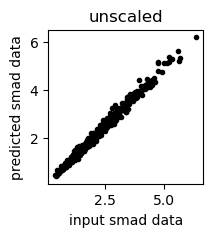

mse =  0.012443747622854403


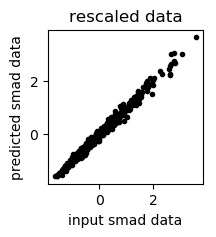

rescaled mse =  0.012248638487612457
{0: 0.012248638487612457}


In [68]:
#can we predict input data well?
xp,xstd = m.predict(X)
# print(xp)

x1 = Y
y1= xp

fig = plt.figure(figsize=(2,2))
plt.scatter(x1,y1,c='k',marker='.')
plt.xlabel('input smad data')
plt.ylabel('predicted smad data')
plt.title('unscaled')
plt.show()
#mse is deviation from identity
mse = np.mean(((x1/np.std(x1))-(y1/np.std(y1)))**2)
print('mse = ',mse.copy())

x1,y1, mse, mseeach = msefunc(xp,Y)


fig = plt.figure(figsize=(2,2))
plt.scatter(x1,y1,c='k',marker='.')
plt.xlabel('input smad data')
plt.ylabel('predicted smad data')
plt.title('rescaled data')
plt.show()
print('rescaled mse = ',mse)
print(mseeach.copy())


In [69]:
def Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr):
    kerndim = X.shape[1]
    ker = GPy.kern.Matern52(kerndim,ARD=True) + GPy.kern.White(kerndim)

    # create simple GP model
    m = GPy.models.GPRegression(X,Y,ker)

    # optimize and plot
    m.optimize(messages=messages,max_f_eval = max_f_eval)
    return m
    
def Gpy_mse_plot(m,X,Y,inputstr,outputstr):
    xp,xstd = m.predict(X)
    x1,y1, mse, mseeach = msefunc(xp,Y)
    msev = np.asarray(list(mseeach.values())).reshape(-1,)
    x1s = x1.shape[1]
    ws = 1
    fig = plt.figure(figsize=((4 + (ws*(x1s-1)))*x1s,4))
    for i in range(0,x1.shape[1]):
        x = x1[:,i]
        y = y1[:,i]
        if x1.shape[1]==1:
            plt.scatter(x,y,c='k',marker='.')
            plt.xlabel('orig.' + outputstr)
            plt.ylabel('pred.' + outputstr)
        else:
            ax = fig.add_subplot(1,x1s,i+1)
            ax.scatter(x,y,c='k',marker='.')
            plt.xlabel('orig.' + outputstr)
            plt.ylabel('pred.' + outputstr)
        if x1.shape[1]>1:
            plt.title('predict ' + outputstr + ' dim-' + str(i+1) + ' based on ' + inputstr)
        else:
            plt.title('predict ' + outputstr + ' based on ' + inputstr)
        ax = plt.gca()
        t = ax.text(0.01,0.99,'rescaled mse = ',transform=ax.transAxes, horizontalalignment='left',verticalalignment='top')
        t = ax.text(0.01,0.95,str(np.round(msev[i],5)),transform=ax.transAxes, horizontalalignment='left',verticalalignment='top')
    plt.show()
    return mseeach

In [70]:
def predSpecificBasedOnDMAP(time_data,ss1,ss2,X,X2,sdat1,sdat2):
    msekeeper={}
    import GPy
    #use Smad Manifold to predicut Smad trajectories (1 timepoint)
    # sample inputs and outputs
    max_f_eval = 1000
    messages=False
    inputstr = ss1 + ' dmaps'
    tvec = time_data[1,:]
    basal = ((np.where(tvec<=0))[0])
    peak = ((np.where(tvec<=30))[0])[-1]

    X=X0.copy()
    outputstr = ss1 + ' tpoint'
    Y = sdat1[:,10].reshape(-1,1) #reshape to look like a 2d input
#     Y = sdat1[:,[5,10,15]]
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach

    X=X0.copy()
    outputstr = ss1 + ' max relative rate'
    
    rate=np.zeros(sdat1.shape[0])
    for j in range(sdat1.shape[0]):
        rate[j] = np.max(sdat1[j,:]/np.median(sdat1[j,basal]))

    Y = rate.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach


    X=X0.copy()
    outputstr = ss1 + ' maximum integral'
    rate=np.zeros(sdat1.shape[0])
    for j in range(sdat1.shape[0]):
        rate[j] = np.max(np.cumsum(sdat1[j,:]))

    Y = rate.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach


    X=X0.copy()
    outputstr = ss1 + ' foldchange at tpeak'
    foldchange = sdat1[:,peak]/np.median(sdat1[:,basal])
    Y = foldchange.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach

    X = X0.copy()
    outputstr = ss1 + ' difference at tpeak'
    foldchange = sdat1[:,peak]-np.median(sdat1[:,basal])
    Y = foldchange.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach


    X=X0.copy()
    outputstr = ss2 + ' difference'
    snaildiff = sdat2[:,peak]-np.median(sdat2[:,basal])
    Y = snaildiff.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach

    X=X0.copy()
    outputstr = ss2 + ' dmap'
    Y = X2.copy()
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach
    
    for v in range(X.shape[1]):
        print(v)
#         outputstr = ss2 + ' dmap, using ' +ss1+ ' ' +str(list(range(1,v+2)))
        inputstr0 = ss1 + ' ' + str(list(range(1,v+2)))
        print(inputstr0)
        X=X0.copy()
        Y = X2.copy()
        m = Gpymadness(X[:,0:v+1],Y,messages,max_f_eval,inputstr0,outputstr)
        mseeach = Gpy_mse_plot(m,X,Y,inputstr0,outputstr)
        msekeeper[outputstr]=mseeach
        
    return msekeeper


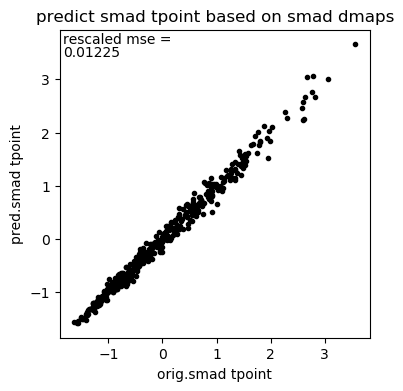

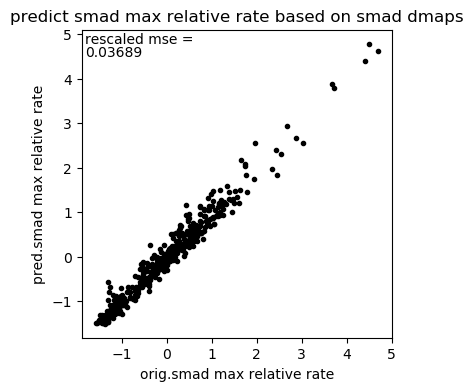

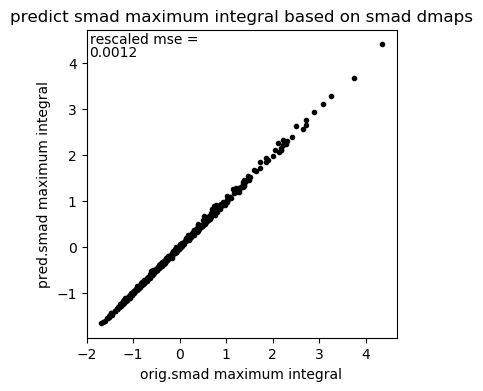

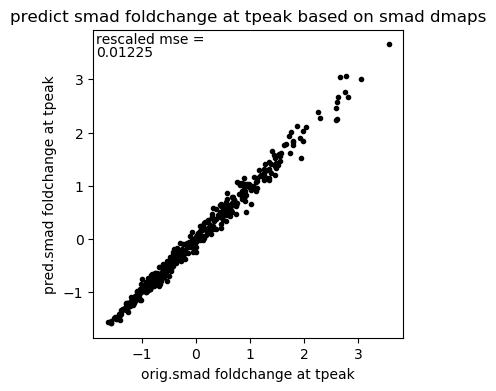

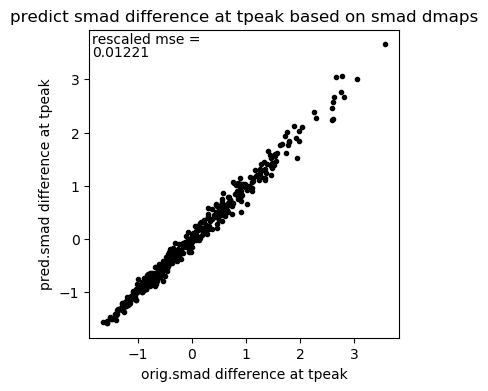

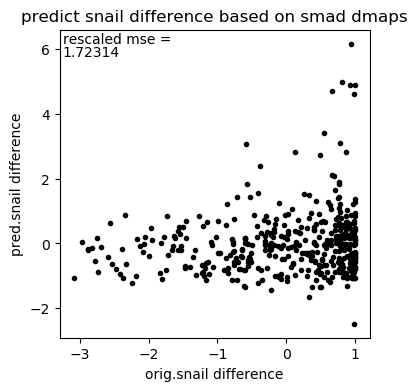

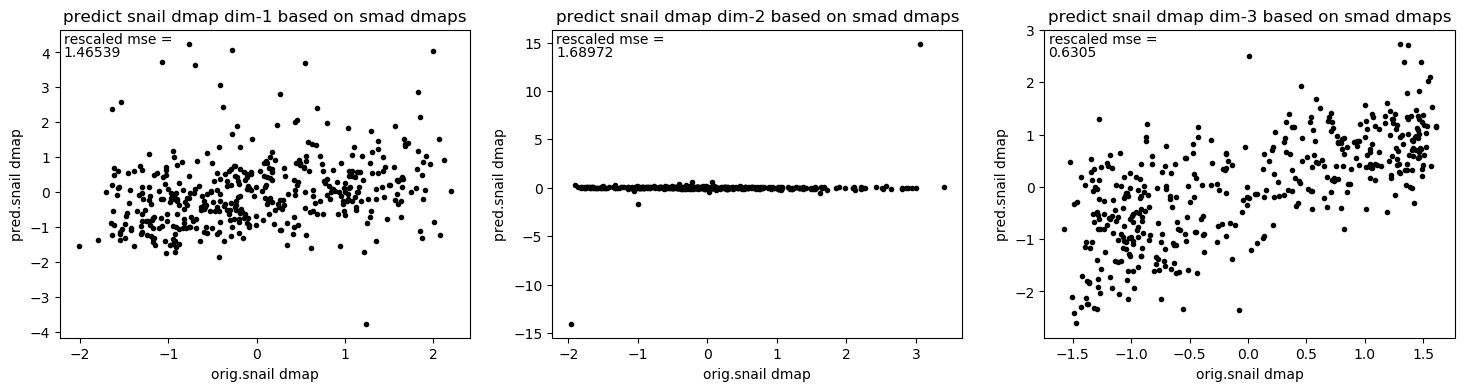

0
smad [1]


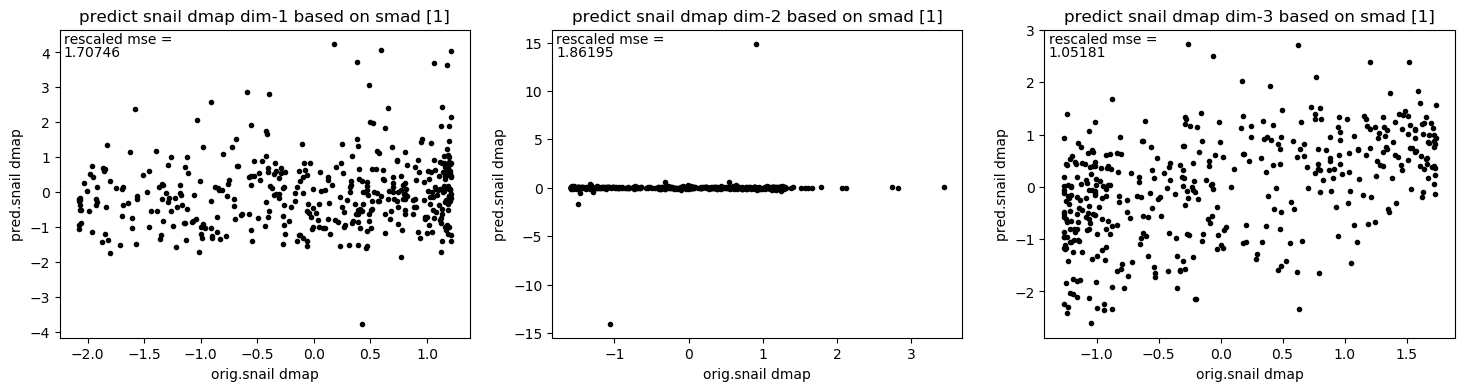

1
smad [1, 2]


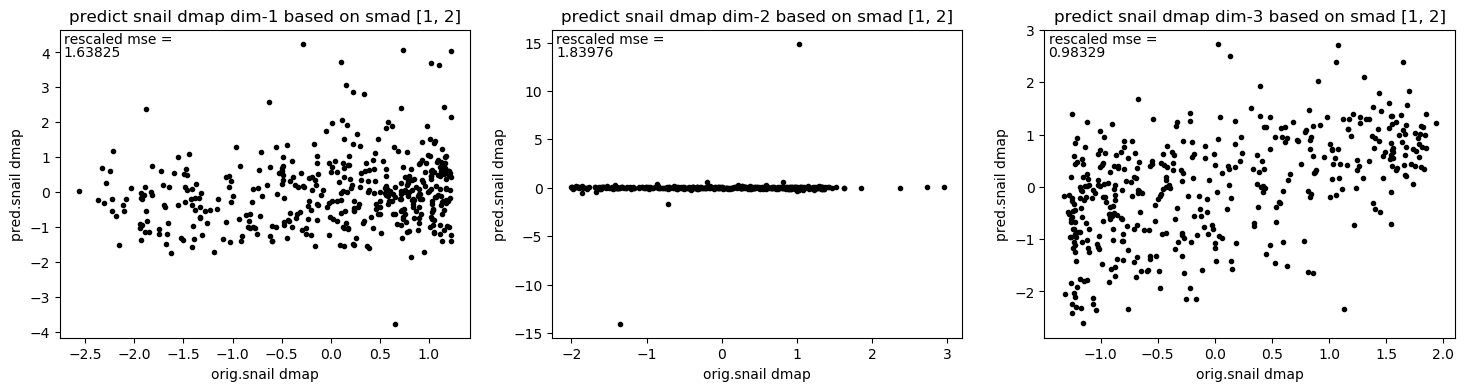

2
smad [1, 2, 3]


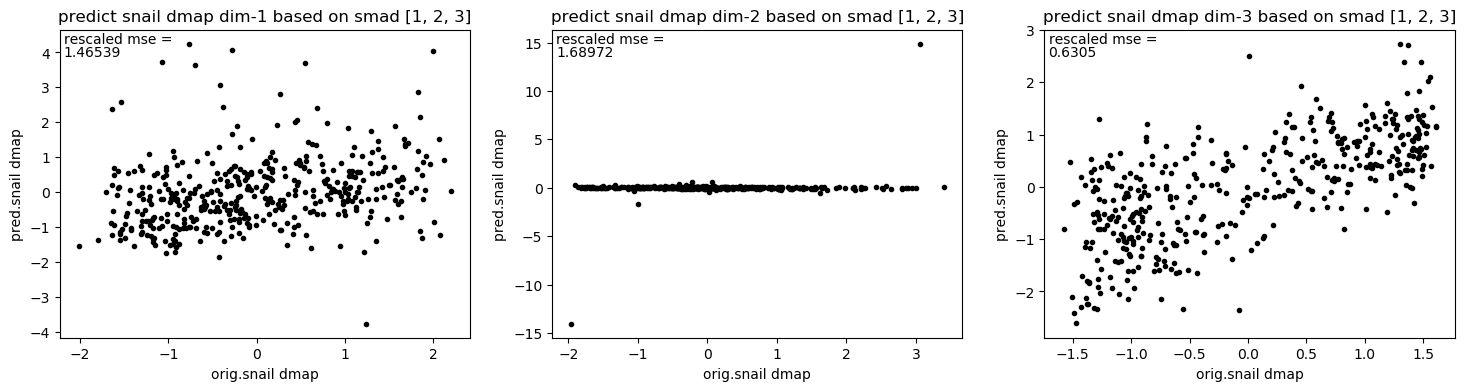

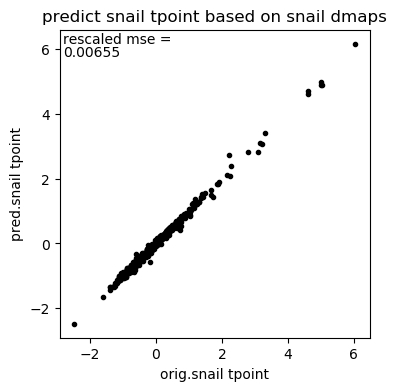

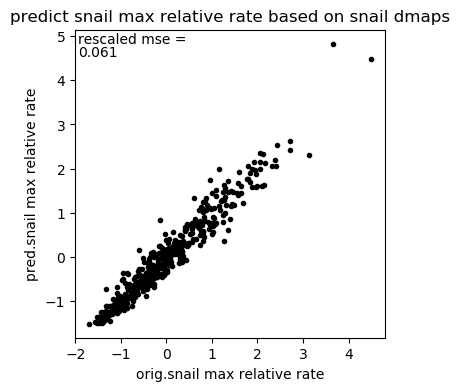

 /Users/frick/anaconda/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/frick/anaconda/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/frick/anaconda/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply


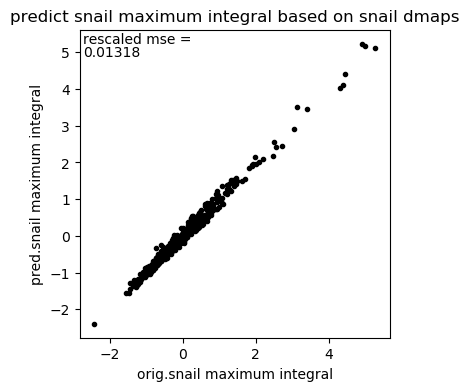

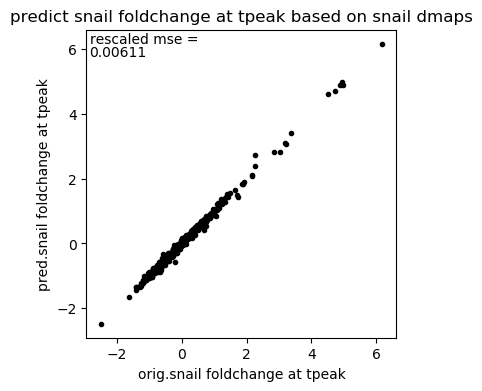

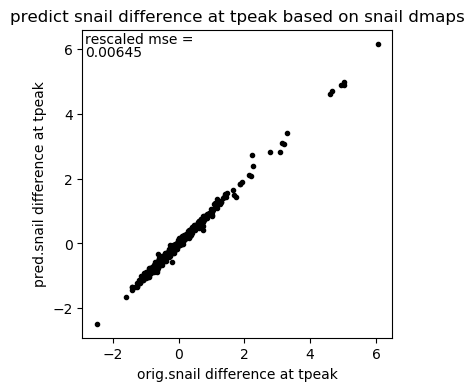

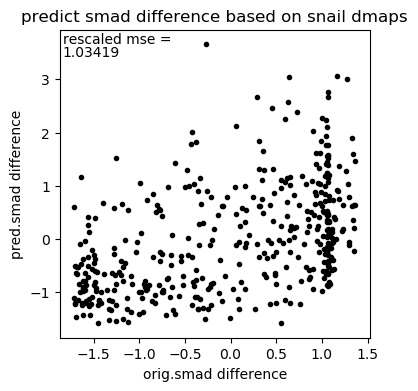

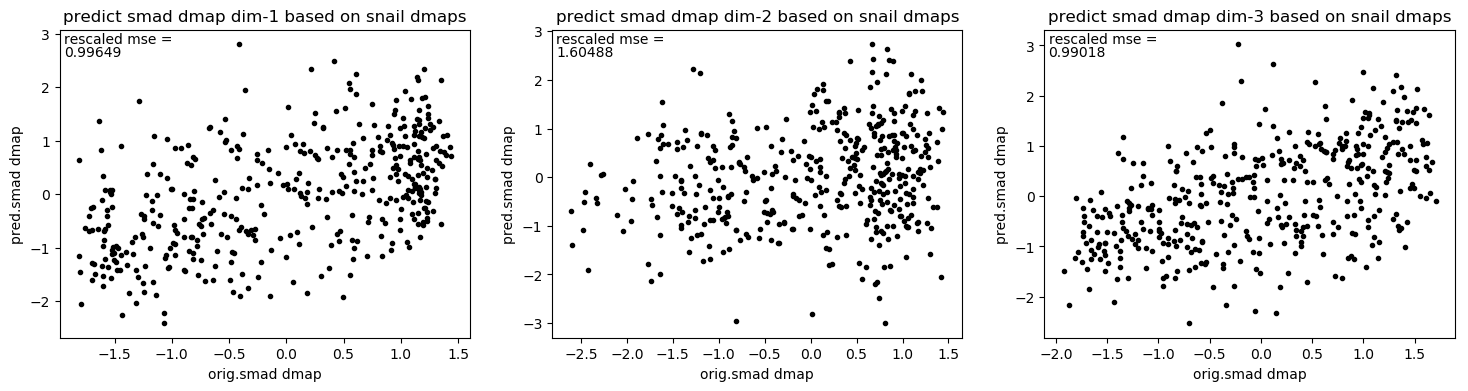

0
snail [1]


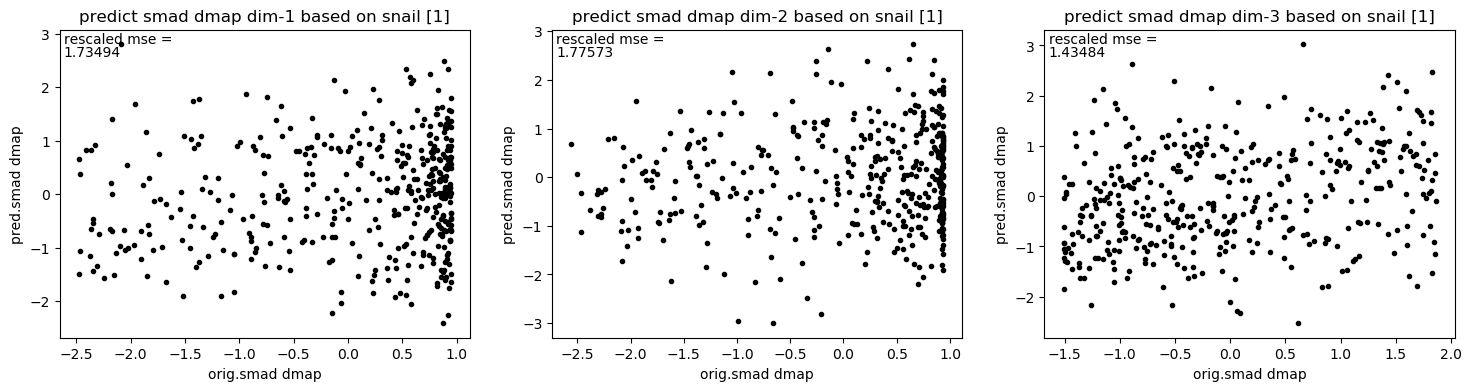

1
snail [1, 2]


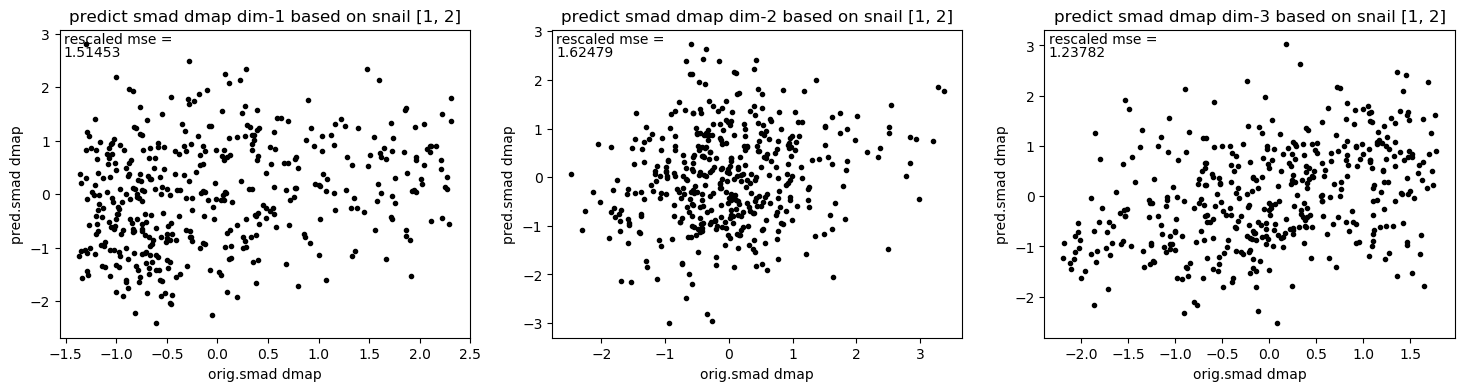

2
snail [1, 2, 3]


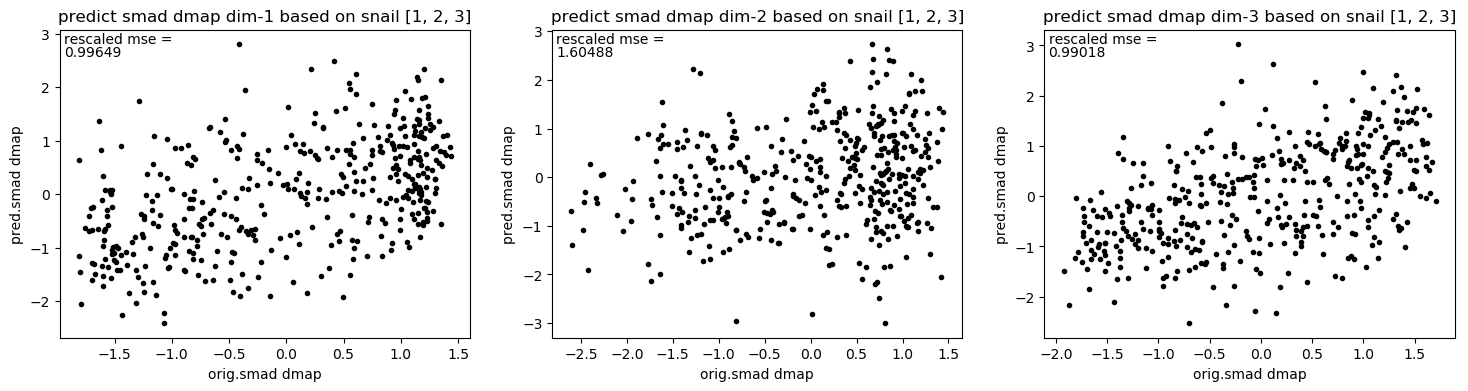

In [71]:
#predictions based on Smad
ss1 = 'smad'
ss2 = 'snail'
X = evecs_in[:,ev_in].copy()
X0=X.copy()
sdat1 = ogdin.copy()
sdat2 = ogdout.copy()
X2 = evecs_out[:,ev_out].copy()
msekeepersmad = predSpecificBasedOnDMAP(time_data,ss1,ss2,X,X2,sdat1,sdat2)

ss1 = 'snail'
ss2 = 'smad'
X = evecs_out[:,ev_out].copy()
X0=X.copy()
sdat1 = ogdout.copy()
sdat2 = ogdin.copy()
X2 = evecs_in[:,ev_in].copy()
msekeepersnail = predSpecificBasedOnDMAP(time_data,ss1,ss2,X,X2,sdat1,sdat2)

In [72]:
def Gpy_eachtpoint(X,Yin0,samp_vec,messages,max_f_eval,inputstr,outputstr):
    Yin = Yin0[:,samp_vec]
    msearray = np.zeros(Yin.shape[1])
    for j in range(0,Yin.shape[1]):
        Y = Yin[:,j].reshape(-1,1)

        max_f_eval = 1000
        messages=False
        m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)

        xp,xstd = m.predict(X)
        x = Y
        y = xp
        x1,y1, mse, mseeach = msefunc(xp,Y)
        msearray[j]=mse
        print(j, end=" " )
    print('completed' + inputstr + outputstr)
    return msearray


In [73]:


time_vec = time_data[1,:]
tsample = 3
tsamp = np.min([tsample,len(time_vec)])

print(len(time_vec))

axfact = 5

ax1 = np.ceil(len(time_vec)/2) - np.ceil(len(time_vec)/5)
ax2 = np.ceil(len(time_vec)/2) + np.ceil(len(time_vec)/5)
samp_vec = np.linspace(ax1,ax2,tsamp,dtype='int32')
print(samp_vec)
print(time_vec[samp_vec])


48
[14 24 34]
[ 44.     83.998 124.   ]


In [74]:
def make_samp_vec(Yin):
    ltv = Yin.shape[1]
    ax1 = np.ceil(ltv/2) - np.ceil(ltv/5)
    ax2 = np.ceil(ltv/2) + np.ceil(ltv/5)
    samp_vec = np.linspace(ax1,ax2,tsamp,dtype='int32')
    return samp_vec

In [75]:

def gpy_each_timepoint(inputstr,X,fsmad,fsmadpro,snaildat,ss1,ss2):
    #attempt to predict input data at all timepoints using Smad Dmaps
    msecombo={} #initialize the master msecombo
    max_f_eval = 1000
    messages = False

    ## run each
    outputstr = ss1 + ' at each tpoint'
    Yin = fsmad
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray


    outputstr = ss2 + ' at each tpoint'
    Yin = snaildat
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray


    outputstr = 'f('+ss1+')'
    Z = fsmad.copy()
    mu, sigma = 0, 0.0 # mean and standard deviation
    for j in range(0,fsmad.shape[1]):
        s = np.random.normal(mu, sigma, fsmad.shape[0])
        Z[:,j] = (fsmad[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray

    
    outputstr = 'f('+ss1+')+smallnoise'
    Z = fsmad.copy()
    mu, sigma = 0, 0.01 # mean and standard deviation
    for j in range(0,fsmad.shape[1]):
        s = np.random.normal(mu, sigma, fsmad.shape[0])
    #     s = np.random.lognormal(mean, sigma, size=fsmad.shape[0])
        Z[:,j] = (fsmad[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray

    
    outputstr = 'f('+ss1+')+mediumnoise'
    Z = fsmad.copy()
    mu, sigma = 0, 0.1 # mean and standard deviation
    for j in range(0,fsmad.shape[1]):
        s = np.random.normal(mu, sigma, fsmad.shape[0])
        Z[:,j] = (fsmad[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray
    
    
    outputstr = 'f('+ss1+'_processed)'
    Z = fsmadpro.copy()
    mu, sigma = 0, 0.0 # mean and standard deviation
    for j in range(0,fsmadpro.shape[1]):
        s = np.random.normal(mu, sigma, fsmadpro.shape[0])
        Z[:,j] = (fsmadpro[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray
    
    outputstr = 'f('+ss1+'_processed)+s_noise'
    Z = fsmadpro.copy()
    mu, sigma = 0, 0.01 # mean and standard deviation
    for j in range(0,fsmadpro.shape[1]):
        s = np.random.normal(mu, sigma, fsmadpro.shape[0])
        Z[:,j] = (fsmadpro[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray
    
    outputstr = 'f('+ss1+'_processed)+m_noise'
    Z = fsmadpro.copy()
    mu, sigma = 0, 0.1 # mean and standard deviation
    for j in range(0,fsmadpro.shape[1]):
        s = np.random.normal(mu, sigma, fsmadpro.shape[0])
        Z[:,j] = (fsmadpro[:,j]**2) + s


    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray


    outputstr = 'noise only'
    Z = fsmad.copy()
    samp_vec = make_samp_vec(Yin)
    mu, sigma = 0, 1 # mean and standard deviation
    for j in range(0,fsmad.shape[1]):
        s = np.random.normal(mu, sigma, fsmad.shape[0])
        Z[:,j] = s

    Yin = Z
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray
    return msecombo

In [76]:
# msecombosmad = msecombo.copy()
inputstr = 'smad dmap'
X = evecs_in[:,ev_in].copy()
fsmad = reducedimensionalityforGPy(ogdin.copy())
fsmadpro = reducedimensionalityforGPy(observed_data_in.copy())
snaildat = reducedimensionalityforGPy(ogdout.copy())
ss1 = 'smad'
ss2 = 'snail'
msecombosmad = gpy_each_timepoint(inputstr,X,fsmad,fsmadpro,snaildat,ss1,ss2)


0 1 2 completedsmad dmapsmad at each tpoint
0 1 2 completedsmad dmapsnail at each tpoint
0 1 2 completedsmad dmapf(smad)
0 1 2 completedsmad dmapf(smad)+smallnoise
0 

 /Users/frick/anaconda/lib/python3.6/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide


1 2 completedsmad dmapf(smad)+mediumnoise
0 1 2 completedsmad dmapf(smad_processed)
0 1 2 completedsmad dmapf(smad_processed)+s_noise
0 1 2 completedsmad dmapf(smad_processed)+m_noise
0 1 2 completedsmad dmapnoise only


In [77]:
inputstr = 'snail dmap'
X = evecs_out[:,ev_in].copy()
fsmad = reducedimensionalityforGPy(ogdout.copy())
fsmadpro = reducedimensionalityforGPy(observed_data_out.copy())
snaildat = reducedimensionalityforGPy(ogdin.copy())
ss1 = 'snail'
ss2 = 'smad'
msecombosnail = gpy_each_timepoint(inputstr,X,fsmad,fsmadpro,snaildat,ss1,ss2)


0 1 2 completedsnail dmapsnail at each tpoint
0 1 2 completedsnail dmapsmad at each tpoint
0 1 2 completedsnail dmapf(snail)
0 1 2 completedsnail dmapf(snail)+smallnoise
0 1 2 completedsnail dmapf(snail)+mediumnoise
0 1 2 completedsnail dmapf(snail_processed)
0 1 2 completedsnail dmapf(snail_processed)+s_noise
0 1 2 completedsnail dmapf(snail_processed)+m_noise
0 1 2 completedsnail dmapnoise only


In [78]:
def msecomboplotter(tvec,msecombo,smadsnail,yl):
    plt.figure(figsize=(5,3))
    subkeep={}
    cycle=0
    for k in msecombo.keys():
        cycle=cycle+1
        v = msecombo[k]
      # k is now the key
      # v is the value
        subkeep[k]=v
        plt.semilogy(tvec+(cycle/100),v,'*-', label=k)
        
    plt.ylim(yl[0],yl[1])
    plt.ylabel('mean square error')
    plt.xlabel('time point, value')
    plt.title('error for different predictions based on '+ smadsnail + ' manifold') 
    plt.legend()
    plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
    plt.show()
        
def msecombomedianplotter(msecombo,smadsnail):
    plt.figure(figsize=(6,3))
    msecombo2 = msecombo.copy()
    cycle=-1
    for k in msecombo.keys():
        y={}
        cycle=cycle+1
        v = msecombo[k]
        y[cycle] = np.median(v)
        msecombo2[k] = y

    cycle=-1
    for k in msecombo2.keys():
        cycle=cycle+1
        v = msecombo2[k]
      # k is now the key
      # v is the value
        y = v.values()
        if len(y)==1:
            x = cycle
            markerstr='o'
        else:
            x = np.linspace(cycle-0.1,cycle+0.1,len(y))
            markerstr='*-'
        plt.semilogy(x,y,markerstr, label=k)
        
            # plt.ylim(0.01,1)
    plt.ylabel('mean square error')
    plt.xlabel('attempted prediction')
    plt.title('error for different predictions based on ' + smadsnail + ' manifold') 
    plt.legend(loc='right',bbox_to_anchor=(1.5, 0.5))
    plt.show()
    
    
def msekeeperplotter(msekeeper2,yl,smadsnail):  
    cycle=-1
    plt.figure(figsize=(4,2))
    for k in msekeeper2.keys():
        cycle=cycle+1
        v = msekeeper2[k]
      # k is now the key
      # v is the value
        y = np.asarray(list(v.values())).reshape(-1,)
        if len(y)==1:
            x = cycle
            markerstr='o'
            msize = 7
            if y<yl[0]:
                x = cycle
                markerstr = 'v'
                print('edited value lower than,', yl[0])
                y = yl[0]*2
                msize=7
        else:
            x = np.linspace(cycle-0.1,cycle+0.1,len(y))
            markerstr='*-'
            msize=7
        plt.semilogy(x,y,markerstr, label=k, markersize = msize)

    plt.ylim(yl[0],yl[1])
    plt.ylabel('mean square error')
    plt.xlabel('attempted prediction')
    plt.title('error for different predictions based on ' + smadsnail + ' manifold') 
    plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
    plt.show()

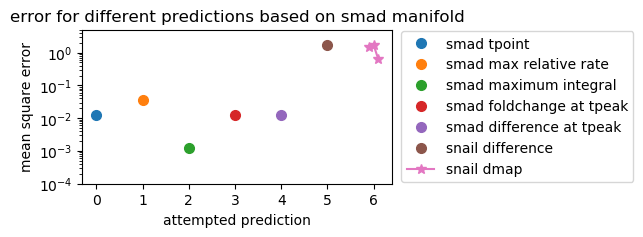

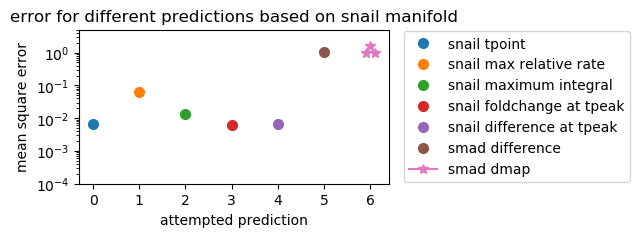

In [79]:
yl = [1e-4,5]
smadsnail='smad'
msekeeperplotter(msekeepersmad,yl,smadsnail)
smadsnail='snail'
msekeeperplotter(msekeepersnail,yl,smadsnail)
   

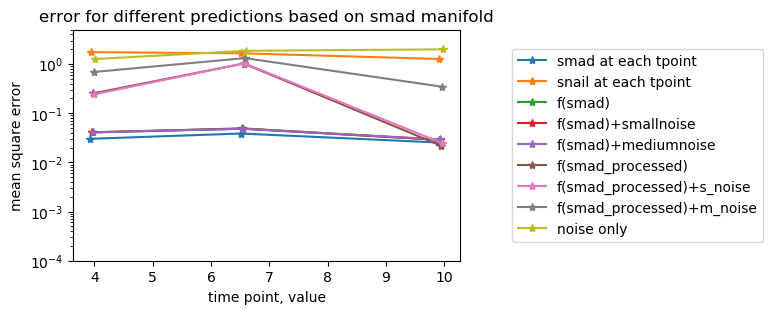

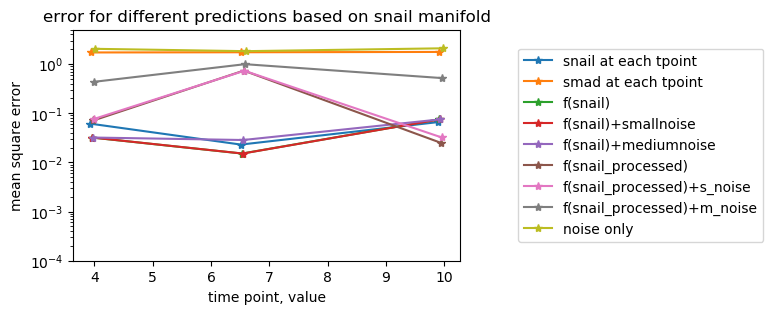

In [80]:


samp_vec = make_samp_vec(time_data_in)
tvec = time_data_in[1,:]
smadsnail = 'smad'
msecomboplotter(tvec[samp_vec]/60,msecombosmad,smadsnail,yl)
smadsnail = 'snail'
msecomboplotter(tvec[samp_vec]/60,msecombosnail,smadsnail,yl)

In [81]:
import dill as pickle;
from pathlib import Path
# import os

# cwd = Path().resolve()
# print(cwd)
# repo = str(cwd) +'/'

session_savepath = 'session' + conditionid + specid + 'clean/'
session_path = repo + session_savepath

print(not (os.path.isdir(session_path)))
if not (os.path.isdir(session_path)):
    print('making' + session_path + '...')
    os.mkdir(session_path)

session_name = 'seshyAfterGPy'
savename = session_path + session_name

pickle.dump_session(savename)
print(savename)
print('pickle success!!!')

False
/Users/frick/Dparams/DParamsFinal_v4/sessionexp3mdl_S3conc_CAGAconc_gpy_-DIFF-positive_LLRpeakfinder_CLEAN-AGNOSTIC-ztosqrtResampleCAGAclean/seshyAfterGPy
pickle success!!!
